# Capestone project: Intent identification and Out-Of-Scope (OOS) detection
# This notebook will be mainly used for the capstone project.



### CRISP-DM Framework

<center>
    <img src = images/crisp.png width = 50%/>
</center>


To frame the task, throughout our practical applications we will refer back to a standard process in industry for data projects called CRISP-DM.  This process provides a framework for working through a data problem.  Your first step in this application will be to read through a brief overview of CRISP-DM [here](https://mo-pcco.s3.us-east-1.amazonaws.com/BH-PCMLAI/module_11/readings_starter.zip). 

In [1]:
import pandas as pd
import json
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import plotly.express as px
import scipy.stats as stats
import time

from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import make_column_transformer, TransformedTargetRegressor
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score, cross_validate, StratifiedKFold, KFold
# halving grid search
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV

from sklearn.linear_model import HuberRegressor, LinearRegression, Lasso, Ridge
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
#create a logistic regression model and fit it to the churn data and classify the data based on "churn" column
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.dummy import DummyClassifier
from sklearn.utils import resample


from sklearn.inspection import permutation_importance
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score
from sklearn import set_config
set_config(display="diagram")
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay
from sklearn.metrics import roc_auc_score,precision_recall_curve, roc_curve,confusion_matrix,accuracy_score, recall_score, precision_score, ConfusionMatrixDisplay

import datetime

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import make_pipeline
from sklearn.calibration import LabelEncoder

# get top text words in the training set
from collections import Counter
# remove stopwords using countvectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')
stop_words = stopwords.words('english')



[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/kiran.ramanna/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import pair_confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
import scikitplot as skplt


import warnings
warnings.filterwarnings('ignore')

from sklearn.exceptions import ConvergenceWarning
# Filter out the convergence warnings
warnings.filterwarnings("ignore", category=ConvergenceWarning)

from IPython.display import display

# Display the warnings as filtered
display(warnings)

# from sklearn.utils.validation import ignore_warnings

import sys
import os

if not sys.warnoptions:
    warnings.simplefilter("ignore")
    os.environ["PYTHONWARNINGS"] = "ignore" # Also affect subprocesses



<module 'warnings' from '/Users/kiran.ramanna/opt/anaconda3/lib/python3.8/warnings.py'>

# 1.Business Understanding
Intent detection is a critical task in Natural Language Understanding (NLU) and Natural Language Processing (NLP) applications. The goal of intent detection is to identify the intent or purpose behind a user's input or query. In other words, it involves classifying a user's input into one of several predefined categories that represent the user's intention or goal.

Intent detection is important in NLU/NLP because it enables machines to understand the meaning of user queries and respond appropriately. By correctly identifying the intent of a user's query, NLU/NLP systems can provide accurate and relevant responses, which is crucial for building conversational interfaces such as chatbots and virtual assistants.

For example, if a user inputs "What is the weather like today?", the intent of the query is to obtain information about the weather. An intent detection system can classify this query as a weather-related intent and provide a response with the current weather information. However, if the intent detection system misclassifies the query, it may provide an irrelevant or incorrect response, leading to a poor user experience.

Therefore, accurate intent detection is essential for building effective NLU/NLP systems that can understand and respond to user queries with high accuracy and relevance.

## 1.1 for this project we will be using the following dataset: https://github.com/clinc/oos-eval


# 2.Data Understand
The Click-150 dataset is a collection of 150 thousand search queries sampled from the Yandex Logs Database. This dataset can be used for various Natural Language Understanding (NLU) tasks such as intent detection, entity recognition, and sentiment analysis.

Intent detection, in particular, is an essential task in the field of NLU and NLP because it helps to identify the purpose or goal of a user's input. In the context of the Click-150 dataset, intent detection can help businesses understand what their users are searching for on their website or app. This knowledge can be used to optimize search results, provide better recommendations, and improve overall user experience.

For example, if a user searches for "hotels in New York", the intent can be identified as "hotel search" and relevant results can be provided to the user. Similarly, if a user searches for "best deals on flights to Paris", the intent can be identified as "flight search" and the user can be provided with relevant offers or deals on flights to Paris. By accurately detecting user intent, businesses can provide personalized and relevant recommendations to their users, which can lead to increased user satisfaction and loyalty.ing


In [3]:
# read oos data
# DATA_OOS_PLUS = 'oos-eval/data/data_oos_plus.json'
# DATA_FULL = 'oos-eval/data/data_full.json'
# DATA_SMALL = 'oos-eval/data/data_small.json'
# oos = json.load(open(DATA_FULL, 'r'))

# directly load data from url into json
import urllib.request, json
with urllib.request.urlopen("https://raw.githubusercontent.com/clinc/oos-eval/master/data/data_oos_plus.json") as url:
    oos = json.loads(url.read().decode())

len(oos)
# show keys
oos.keys()

dict_keys(['oos_val', 'val', 'train', 'oos_test', 'test', 'oos_train'])

#### 2.1
- oos dataset has 6 keys. Looks like data is already segregated into train, test and validation sets. We will use the train set for training and validation set for testing our model.
- Next Lets look at the samples in each of the keys.

In [4]:


#create a dataframe from json, with column names ['text', 'intent']
def create_df_from_json(path):
    data = json.load(open(path, 'r'))
    df = pd.DataFrame(data)
    df = df[['text', 'intent']]
    return df



INTENT_COLUMN = 'intent'
TEXT_COLUMN = 'text'

df_train = pd.DataFrame.from_dict(oos['train'])
df_train.rename(columns={0:TEXT_COLUMN, 1:INTENT_COLUMN}, inplace=True)
print(f'train set : {df_train.shape}: unique intents {df_train[INTENT_COLUMN].nunique()}')

df_test = pd.DataFrame.from_dict(oos['test'])
df_test.rename(columns={0:TEXT_COLUMN, 1:INTENT_COLUMN}, inplace=True)
print(f'test set : {df_test.shape}: unique intents {df_test[INTENT_COLUMN].nunique()}')

df_val = pd.DataFrame.from_dict(oos['val'])
df_val.rename(columns={0:TEXT_COLUMN, 1:INTENT_COLUMN}, inplace=True)
print(f'val set : {df_val.shape}: unique intents {df_val[INTENT_COLUMN].nunique()}')



df_train_oos = pd.DataFrame.from_dict(oos['oos_train'])
df_train_oos.rename(columns={0:TEXT_COLUMN, 1:INTENT_COLUMN}, inplace=True)
print(f'df_train_oos set : {df_train_oos.shape}: unique intents {df_train_oos[INTENT_COLUMN].nunique()}')

df_test_oos = pd.DataFrame.from_dict(oos['oos_test'])
df_test_oos.rename(columns={0:TEXT_COLUMN, 1:INTENT_COLUMN}, inplace=True)
print(f'df_test_oos set : {df_test_oos.shape}: unique intents {df_test_oos[INTENT_COLUMN].nunique()}')


df_val_oos = pd.DataFrame.from_dict(oos['oos_val'])
df_val_oos.rename(columns={0:TEXT_COLUMN, 1:INTENT_COLUMN}, inplace=True)
print(f'df_val_oos set : {df_val_oos.shape}: unique intents {df_val_oos[INTENT_COLUMN].nunique()}')

# full dataset
# train set : (15000, 2): unique intents 150
# test set : (4500, 2): unique intents 150
# val set : (3000, 2): unique intents 150
# df_train_oos set : (250, 2): unique intents 1
# df_test_oos set : (1000, 2): unique intents 1
# df_val_oos set : (100, 2): unique intents 1


train set : (15000, 2): unique intents 150
test set : (4500, 2): unique intents 150
val set : (3000, 2): unique intents 150
df_train_oos set : (250, 2): unique intents 1
df_test_oos set : (1000, 2): unique intents 1
df_val_oos set : (100, 2): unique intents 1


#### 2.2
- for oos intent, we have 1250 samples and known intents we have 22500 samples when all the data is combined.

In [5]:
# create X, y
X_train = df_train[[TEXT_COLUMN]]
y_train = df_train[INTENT_COLUMN]

X_test = df_test[[TEXT_COLUMN]]
y_test = df_test[INTENT_COLUMN]

X_val = df_val[[TEXT_COLUMN]]
y_val = df_val[INTENT_COLUMN]


In [6]:
# check shape of each dataframes
print(f'X_train shape: {X_train.shape}, y_train shape: {y_train.shape}')
print(f'X_test shape: {X_test.shape}, y_test shape: {y_test.shape}')
print(f'X_val shape: {X_val.shape}, y_val shape: {y_val.shape}')


X_train shape: (15000, 1), y_train shape: (15000,)
X_test shape: (4500, 1), y_test shape: (4500,)
X_val shape: (3000, 1), y_val shape: (3000,)


In [7]:
# count unique intents
print(f'total unique intents other than oos in each set: train {y_train.nunique()}, test {y_test.nunique()}, val {y_val.nunique()}')

total unique intents other than oos in each set: train 150, test 150, val 150


#### 2.3
- All the data is in text format.
- We will need to use label encoder to convert the text to numbers for training the model.

# 3. Data Preparation
- Now that we have the data, we need to prepare it for training the model.
- We will use label encoder to convert the text to numbers for training the model.
- We will use the train set for training and validation set for testing our model.

In [8]:

# def get_top_text_words(X_train, n=10):
#     vectorizer = TfidfVectorizer(stop_words='english')
#     vectorizer.fit_transform(X_train)
#     words = vectorizer.get_feature_names_out()
#     total_counts = X_train.sum(axis=0).tolist()[0]
#     counter = Counter(dict(zip(words, total_counts)))
#     most_common = counter.most_common(n)
#     return most_common

# # plot top text words
# import matplotlib.pyplot as plt
# import seaborn as sns
# def plot_top_text_words(X_train, n=10):
#     most_common = get_top_text_words(X_train, n)
#     print("most_common", most_common)
#     words = [w[0] for w in most_common]
#     counts = [w[1] for w in most_common]
#     sns.barplot(x=counts, y=words)
#     plt.title(f'{n} most common words')
#     plt.show()

# # plot_top_text_words(X_train, 10)


In [9]:
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.fit_transform(y_test)
y_val = le.fit_transform(y_val)

# 4. Modeling

Lets start with a dummy model to get a baseline accuracy. We will use the test set to test the model.

In [10]:
def printAvgClassificationReport(report):
    # Convert the report to a data frame
    report_df = pd.DataFrame(report).transpose()
    index_values = ['macro avg', 'weighted avg']
    filtered_df = report_df[report_df.index.isin(index_values)]

    print(f'accuracy: {report_df.loc["accuracy", "support"]}')
    print(filtered_df)


In [11]:
# dummy classifier
from sklearn.dummy import DummyClassifier
dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(X_train[TEXT_COLUMN], y_train)
y_pred = dummy_clf.predict(X_test[TEXT_COLUMN])
# print(classification_report(y_test, y_pred, target_names=le.classes_))
printAvgClassificationReport(classification_report(y_test, y_pred, output_dict=True))



accuracy: 0.006666666666666667
              precision    recall  f1-score  support
macro avg      0.000044  0.006667  0.000088   4500.0
weighted avg   0.000044  0.006667  0.000088   4500.0


#### 4.1
- Accuracy of the dummy model is 0.01
- This is the baseline accuracy for our model. Any model we build should have accuracy greater than this.

#### 4.2
- We will use SGDClassifier to train our model as a basic valid model.

In [12]:
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.fit_transform(y_test)
y_val = le.fit_transform(y_val)

model = make_pipeline(TfidfVectorizer(stop_words='english'), 
              SGDClassifier())
model.fit(X_train[TEXT_COLUMN], y_train)

Pipeline(steps=[('tfidfvectorizer', TfidfVectorizer(stop_words='english')),
                ('sgdclassifier', SGDClassifier())])

In [13]:

y_pred = model.predict(X_test[TEXT_COLUMN])

y_test = le.transform(y_test)
y_pred = le.transform(y_pred)
y_val = le.transform(y_val)

printAvgClassificationReport(classification_report(y_test, y_pred, output_dict=True))



accuracy: 0.8106666666666666
              precision    recall  f1-score  support
macro avg      0.822937  0.810667   0.80478   4500.0
weighted avg   0.822937  0.810667   0.80478   4500.0


#### 4.3
- Accuracy of the SGDClassifier model is 0.81
- This is a good accuracy for our model. We will try to improve this accuracy by using different models.

4.4 
- Lets see top 10 words in train and test set.

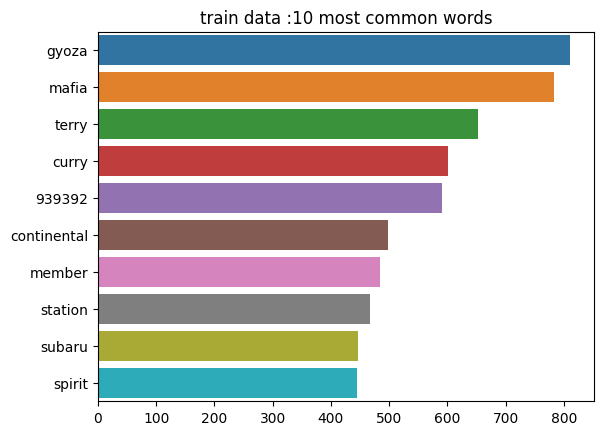

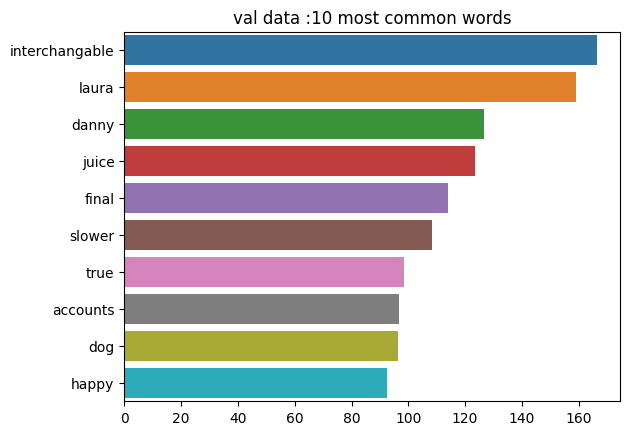

In [14]:

def plot_top_text_words(X_train, n, title):
    vectorizer = TfidfVectorizer()
    X_train_vect = vectorizer.fit_transform(X_train)
    word_counts = X_train_vect.sum(axis=0).tolist()[0]
    words = [word for word, count in sorted(zip(vectorizer.vocabulary_.keys(), word_counts), key=lambda pair: pair[1], reverse=True)[:n]]
    counts = [count for word, count in sorted(zip(vectorizer.vocabulary_.keys(), word_counts), key=lambda pair: pair[1], reverse=True)[:n]]
    sns.barplot(x=counts, y=words)
    plt.title(f'{title} data :{n} most common words')
    plt.show()

    
plot_top_text_words(X_train[TEXT_COLUMN], 10, 'train')


# plot top text words
plot_top_text_words(X_val[TEXT_COLUMN], 10, 'val')


4.4.1
 - Based on the above gyoza, mafia, terry seems to be the most frequent words in the train set.
- Based on the above interchangable, laura and danny seems to be the most frequent words in the validation set.
 

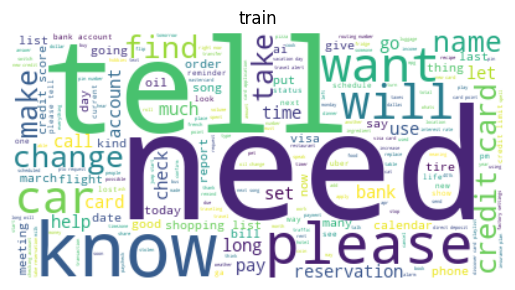

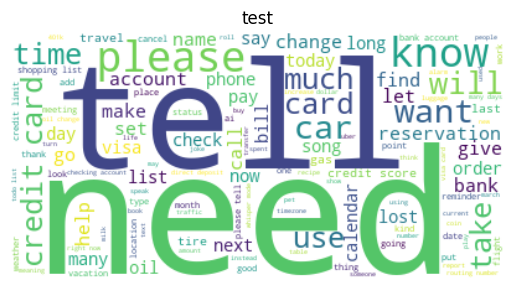

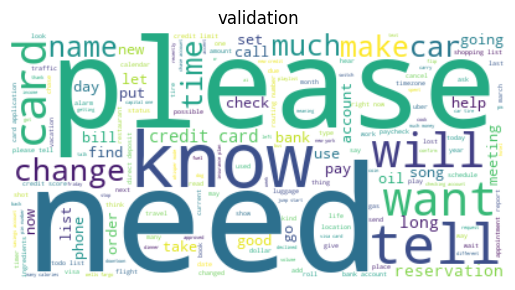

In [15]:
# word cloud
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt

def plot_word_cloud(X_train, title):
    text = " ".join(review for review in X_train[TEXT_COLUMN])
    stopwords = set(STOPWORDS)
    stopwords.update(["br", "href"])
    wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(text)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(title)
    plt.show()

plot_word_cloud(X_train, 'train')
plot_word_cloud(X_test, 'test')
plot_word_cloud(X_val, 'validation')


4.4.2:
 - tell, need, know, please are some of the most common words in all train, val and test sets

In [16]:
# plot confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def plot_confusion_matrix(y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(10, 10))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()
    
# plot_confusion_matrix(y_test, y_pred)

4.5
- Lets create few reusable functions to train and test the model.

In [17]:
# 4.5.1 create a dataframe for capturing model performance and results
dict = {'model': [],
        'train_acc': [],
        'test_acc': [],
        'val_acc': [],
        'time': [],
        'split': [],
        'grid': [],
        'data': [],
        'precision' : [],
        'recall' : [],
        'f1-score' : [],
        'support' : [],
        'timestamp' : []}
out_df = pd.DataFrame(dict)
# columns to show in model performance dataframe
model_building_cols = ['model', 'data', 'train_acc', 'test_acc', 'time', 'split', 'precision', 'recall', 'f1-score', 'support']
evaluation_cols = ['model', 'data', 'val_acc', 'time', 'precision', 'recall', 'f1-score', 'support']


In [18]:
# 5.3 Few reusable functions to validate binary classifiers

# plot roc curve
def plot_confusion_matrix(y_test, y_pred, ax):
    threshold = 0.5
    y_pred_binary = np.where(y_pred[:, 1] >= threshold, 1, 0)
    fig = ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred_binary), display_labels=['in-scope', 'oos']).plot(ax=ax)
    # fig.ax_.set_title('Confision Matrix : predict_proba (threshold = 0.5)')
    # split title in 2 lines
    title = 'Confision Matrix : predict_proba (threshold = 0.5)'.split(':')
    fig.ax_.set_title(title[0] + ':\n' + title[1], loc='left')
    # move title up
    fig.ax_.title.set_position([.5, 1.05])
    # set sub title
    # fig.im_.colorbar.remove()
    

def plot_roc_curve(y_test, y_pred, ax):
    fpr, tpr, _ = roc_curve(y_test, y_pred[:, 1])
    roc_auc = auc(fpr, tpr)
    ax.plot(fpr, tpr, label=f'auc = {roc_auc:.2f}')
    ax.plot([0, 1], [0, 1], 'k--')
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    # show grid
    ax.grid(True)
    ax.legend(loc='lower right')
    ax.set_title('ROC Curve')
    
    
# plot cumilative gains curve and lift curve
def plot_cumulative_gains_curve(y_test, y_pred, ax):
    skplt.metrics.plot_cumulative_gain(y_test, y_pred, ax=ax)
    
def plot_lift_curve(y_test, y_pred, ax):
    skplt.metrics.plot_lift_curve(y_test, y_pred, ax=ax)

    
def plotAll3(y_test, y_pred):
    fig, ax = plt.subplots(1, 4, figsize=(20, 5))
    fig.suptitle('ROC Curve, Cumulative Gains Curve, Lift Curve')
    plot_confusion_matrix(y_test, y_pred, ax=ax[0])
    plot_roc_curve(y_test, y_pred, ax=ax[1])
    plot_cumulative_gains_curve(y_test, y_pred, ax=ax[2])
    plot_lift_curve(y_test, y_pred, ax=ax[3])
    plt.show()
    


In [19]:
# 4.5.2 create a reusable function to save each model's performance and results

def calcOutRow(model, name, X_train, X_test, y_train, y_test, X_val, y_val, split, dataCSVName, timeTaken, gridSearch):
    y_pred = model.predict(X_test)
    # if dataCSVName contains 'oos', then use X_val, y_val
    if 'oos' in dataCSVName:
        # print('shape of y_pred:', y_pred.shape, 'shape of y_test:', y_test.shape, 'shape of X_test:', X_test.shape)
        # print classification report
        print(classification_report(y_test, y_pred, target_names=list(map(str, le.classes_))))
        plotAll3(y_test, model.predict_proba(X_test))

    start = time.time()
    report = classification_report(y_test, y_pred, output_dict=True)
    end = time.time()
    report_df = pd.DataFrame(report).transpose()
    print(f"Time taken to run classification_report: {end - start}")
    report_df.columns = ['precision', 'recall', 'f1-score', 'support']
    rowIndexName = 'True'
    if 'True' in report_df.index:
        report_df.loc['True']
        rowIndexName = 'True'
    else:
        # report_df.drop(['accuracy', 'macro avg', 'weighted avg'], inplace=True)
        report_df.loc['mean'] = report_df.mean()
        rowIndexName = 'mean'
    eachRow = {'model':name,
        'train_acc': model.score(X_train, y_train),
        'test_acc': model.score(X_test, y_test),
        'val_acc': model.score(X_val, y_val),
        'time': np.round(timeTaken, 4),
        'split': split,
        'grid': gridSearch,
        'data': dataCSVName,
        'precision' : report_df.loc[rowIndexName]['precision'],
        'recall' : report_df.loc[rowIndexName]['recall'],
        'f1-score' : report_df.loc[rowIndexName]['f1-score'],
        'support' : report_df.loc[rowIndexName]['support'],
        'timestamp' : datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")
        }
    out_df.loc[len(out_df)] = eachRow
    

In [20]:
# 4.5.3 create a reusable function to fit and predict model

def calcAcc_score(data_df, X_columns, y_columns, model_pipe, name, grid_param, split, dataCSVName):
    warnings.filterwarnings("ignore", category=ConvergenceWarning)
    if not sys.warnoptions:
        warnings.simplefilter("ignore")
        os.environ["PYTHONWARNINGS"] = "ignore" # Also affect subprocesses

    print(f'######## calcAcc_score {name} - {dataCSVName} start - {time.ctime()} ########')
    # X = data_df[X_columns]
    # y = data_df[y_columns]
    # X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=split, random_state=42)
    start = time.time()
    model = model_pipe.fit(X_train, y_train)
    end = time.time()
    print(f'basic fit {name} timetaken: {end-start}')
    print(f'{name}', f'      split :{split} Train ACC: {model.score(X_train, y_train)}')
    print(f'{name}', f'      split :{split} Test ACC: {model.score(X_test, y_test)}')
    print(f'{name}', f'      split :{split} Val ACC: {model.score(X_val, y_val)}')
    calcOutRow(model, name, X_train, X_test, y_train, y_test, X_val, y_val, split, dataCSVName, end-start, 'No')
    # if (name == 'DecisionTreeClassifier' or name == 'LogisticRegression' or name == 'KNeighborsClassifier' or name == 'SVC'):
    # if (grid_param is not None):
    #     # calculate permutation importance
    #     # print('start permutation importance'+time.ctime())
    #     start = time.time()
    #     perm_importance = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2)
    #     end = time.time()
    #     # select top 10 features into list
    #     top10important = X_test.columns[np.argsort(perm_importance.importances_mean)[-10:]].tolist()
    #     # plot permutation importance for top 10 features
    #     sorted_idx = perm_importance.importances_mean.argsort()
    #     plt.boxplot(perm_importance.importances[sorted_idx].T, vert=False, labels=X_test.columns[sorted_idx])
    #     plt.title("Permutation Importances:"+name +" timetaken:"+str(end-start))
    #     plt.show()
    # else:

        
    if grid_param is None:
        return

    # X_train_grid, X_test_grid, y_train_grid, y_test_grid = train_test_split(X, y, test_size=split, random_state=42)
    X_train_grid = X_train
    X_test_grid = X_test
    y_train_grid = y_train
    y_test_grid = y_test
    X_val_grid = X_val
    y_val_grid = y_val
    
    start = time.time()
    grid_val = 'halving'
    # randomizedsearchcv
    # grid = RandomizedSearchCV(model_pipe, grid_param, n_iter=10, cv=5, verbose=1, random_state=42, n_jobs=2)
    # halving grid search
    grid = HalvingGridSearchCV(model_pipe, grid_param, cv=5, verbose=1, random_state=42, n_jobs=2)
    

    # grid = GridSearchCV(model_pipe, grid_param)
    grid.fit(X_train_grid, y_train_grid)
    end = time.time()
    print(f'{name}-grid', f' split :{split} Train ACC: {grid.best_estimator_.score(X_train_grid, y_train_grid)}, grid-fit timetaken: {end-start}')
    print(f'{name}-grid', f' split :{split} Test ACC: {grid.best_estimator_.score(X_test_grid, y_test_grid)}')
    calcOutRow(grid.best_estimator_, name, X_train_grid, X_test_grid, y_train_grid, y_test_grid, X_val_grid, y_val_grid, split, dataCSVName, end-start, grid_val)
    print(f'{name}-grid', f' split :{split} best params', grid.best_params_)
    y_pred_grid = grid.best_estimator_.predict(X_test_grid)
    # print(classification_report(y_test_grid, y_pred_grid))
    printAvgClassificationReport(classification_report(y_test_grid, y_pred_grid, output_dict=True))
    print(f'######## calcAcc_score {name} end ########')
    # plotConfusionMatrics(name, model, grid.best_estimator_, X_test, y_test, X_test_grid, y_test_grid)

    

In [21]:
# 4.5.4 create a reusable function to test differnt classifiers namely:
# DecisionTreeClassifier,
# LogisticRegression,
# KNeighborsClassifier,
# SVC,
# RandomForestClassifier,
# XGBClassifier
# This also does grid search for each classifier


def validateClassifiers( preprocessor, data_df, X_columns, y_columns, dataCSVName):
    # for i in [0.1, 0.2, 0.3, 0.4]:
    random_state = 42
    for i in [0.2]:
        #1. DecisionTreeClassifier
        dt_pipe = Pipeline(steps=[
            ('preprocessor', preprocessor),
            ('classifier', DecisionTreeClassifier(random_state=random_state))])

        dt_params = {'classifier__min_impurity_decrease': np.logspace(-3, 3, 7),
                'classifier__max_depth': np.arange(2, 11, 2),
                'classifier__min_samples_split': np.logspace(-2, 2, 5)}
        calcAcc_score(data_df, X_columns, y_columns, dt_pipe, 'DecisionTreeClassifier', dt_params, i, dataCSVName)

        # #2. LogisticRegression
        lr_pipe = Pipeline(steps=[
            ('preprocessor', preprocessor),
            ('classifier', LogisticRegression(random_state=random_state))])

        lr_params = {
            'classifier__penalty': ['l1', 'l2'],
            'classifier__C': np.logspace(-1, 1, 3),
            'classifier__solver': ['liblinear', 'saga'],
            'classifier__max_iter': [100]
        }
        calcAcc_score(data_df, X_columns, y_columns, lr_pipe, 'LogisticRegression', lr_params, i, dataCSVName)

        # #3. KNeighborsClassifier
        knn_pipe = Pipeline(steps=[
            ('preprocessor', preprocessor),
            ('classifier', KNeighborsClassifier())])

        knn_params = {
            'classifier__n_neighbors': np.linspace(100, 3000, 10, dtype=int),
            'classifier__weights': ['uniform', 'distance'],
            'classifier__metric': ['euclidean', 'manhattan']
        }
        calcAcc_score(data_df, X_columns, y_columns, knn_pipe, 'KNeighborsClassifier', knn_params, i, dataCSVName)

        #4. SVC
        # choose proper class_weight 
        svc_pipe = Pipeline(steps=[
            ('preprocessor', preprocessor),
            ('classifier', SVC(random_state=random_state, probability=True))])


        svc_params = {
            'classifier__kernel': ['linear', 'poly', 'rbf', 'sigmoid']
        }
        calcAcc_score(data_df, X_columns, y_columns, svc_pipe, 'SVC', svc_params, i, dataCSVName)

        # #5. RandomForestClassifier
        rf_pipe = Pipeline(steps=[
            ('preprocessor', preprocessor),
            ('classifier', RandomForestClassifier(random_state=random_state))])
        
        rf_params = {
            'classifier__n_estimators': [100, 300, 500],
            'classifier__bootstrap': [True, False]
        }
        calcAcc_score(data_df, X_columns, y_columns, rf_pipe, 'RandomForestClassifier', rf_params, i, dataCSVName)
        
        # #6. XGBClassifier
        xgb_pipe = Pipeline(steps=[
            ('preprocessor', preprocessor),
            ('classifier', XGBClassifier(random_state=random_state))])
        
        xgb_params = {
            'classifier__n_estimators': [100, 300, 500],
            'classifier__gamma': [0.0, 0.1, 0.3]
        }
        calcAcc_score(data_df, X_columns, y_columns, xgb_pipe, 'XGBClassifier', xgb_params, i, dataCSVName)
        


In [22]:
# 4.5.5 label encoder for y_train, y_test, y_val
# - Also create a column transformer to check 2 different vectorizers
# (1)) TfidfVectorizer
# (2)) CountVectorizer

# tfidf vectorizer
tfidf = TfidfVectorizer(stop_words='english')

# count vectorizer
count = CountVectorizer(stop_words='english')

# label encoder
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(y_train)
y_train = le.transform(y_train)
le.fit(y_test)
y_test = le.transform(y_test)
le.fit(y_val)
y_val = le.transform(y_val)


preprocessor_tfidf = make_column_transformer(
    (tfidf, TEXT_COLUMN),
    remainder='passthrough')

preprocessor_count = make_column_transformer(
    (count, TEXT_COLUMN),
    remainder='passthrough')



In [23]:
def plotAccuracies(orig_df, split, grid, dataCSVName):
    # subplot graph showing train and test accuracy for each classifier where grid search was used
    # and where it was not used
    out_df = orig_df[orig_df['data'] == dataCSVName]
    if(out_df.empty):
        print(f'No data found for this dataset "{dataCSVName}" and split size {split}')
        return
    sns.set_style("whitegrid")
    sns.set(rc={'figure.figsize':(20, 10)})
    sns.set(font_scale=1.5)
    sns.set_style("ticks")
    sns.set_style({"xtick.direction": "in","ytick.direction": "in"})
    sns.set_style({"xtick.bottom": True, "ytick.left": True})

    # select rows where grid search was used and where it was not used for split size 0.2
    plot_data = out_df[out_df['grid'] == grid][out_df['split']==split].sort_values(by='time', ascending=False)

    fig, ax = plt.subplots(1, 1, sharey=True)
    # increase space between subplots
    fig.subplots_adjust(wspace=0.1)
    # plot train and test accuracy in same plot
    plot_data.plot.bar(x='model', y=['train_acc', 'test_acc', 'precision', 'recall', 'f1-score'], ax=ax)
    # show value of test and train accuracy on bar plot for each column and put it on top of bar
    for i, v in enumerate(plot_data['train_acc']):
        ax.text(i-.25, v+.01, str(np.round(v, 2)), color='blue', fontweight='bold') # first index is horizontal, second is vertical
    for i, v in enumerate(plot_data['test_acc']):
        ax.text(i+.01, v+.01, str(np.round(v, 2)), color='orange', fontweight='bold')


    # use twinx to plot time on same plot
    ax2 = ax.twinx()
    plot_data.plot.line(x='model', y='time', ax=ax2, color='black', marker='o')
    plot_data.plot.scatter(x='model', y='time', ax=ax2, color='black', marker='o')
    # show value of time on scatter plot
    for i, v in enumerate(plot_data['time']):
        ax2.text(i, v, str(np.round(v, 2)), color='black', fontweight='bold')

    #ax2 set ylabel false to avoid duplicate labels
    ax2.set_ylabel('')


    # set plot titles and labels # set title higher to avoid overlapping with legend
    if grid == 'Yes':
        ax.set_title(f'Grid Search Used - Split Size {split}', y=1.05)
    else:
        ax.set_title(f'Base classifier - Split Size {split}', y=1.05)

    ax.set_xlabel('Classifiers')
    ax.set_ylabel('Test and Train Accuracy')
    ax.set_ylim(0, 1)
    plt.setp(ax.get_xticklabels(), rotation=75)
    # move legend to top right
    ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
    # move ax2 legend below ax legend
    ax2.legend(loc='upper left', bbox_to_anchor=(1, 0.7))

    plt.suptitle(f'Train and Test Accuracy for dataset:{dataCSVName}, split:{split}', fontsize=20)
    # plt.savefig(f'images/{dataCSVName}.png', format="png", bbox_inches='tight')
    plt.show()


In [24]:
# 4.5.6 run classifiers for validation for tfidf vectorizer
import warnings

# Set the warning filter globally to ignore
warnings.filterwarnings("ignore", category=ConvergenceWarning)

validateClassifiers(preprocessor_tfidf, df_train, TEXT_COLUMN, INTENT_COLUMN, 'clinc150-tfidf')


######## calcAcc_score DecisionTreeClassifier - clinc150-tfidf start - Tue May 16 23:34:07 2023 ########
basic fit DecisionTreeClassifier timetaken: 2.102752923965454
DecisionTreeClassifier       split :0.2 Train ACC: 0.979
DecisionTreeClassifier       split :0.2 Test ACC: 0.7424444444444445
DecisionTreeClassifier       split :0.2 Val ACC: 0.7483333333333333
Time taken to run classification_report: 0.015787839889526367
n_iterations: 3
n_required_iterations: 5
n_possible_iterations: 3
min_resources_: 1500
max_resources_: 15000
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 175
n_resources: 1500
Fitting 5 folds for each of 175 candidates, totalling 875 fits
----------
iter: 1
n_candidates: 59
n_resources: 4500
Fitting 5 folds for each of 59 candidates, totalling 295 fits
----------
iter: 2
n_candidates: 20
n_resources: 13500
Fitting 5 folds for each of 20 candidates, totalling 100 fits
DecisionTreeClassifier-grid  split :0.2 Train ACC: 0.07086666666666666, grid-

In [25]:
# 4.5.7 run classifiers for validation for count vectorizer
validateClassifiers(preprocessor_count, df_train, TEXT_COLUMN, INTENT_COLUMN, 'clinc150-count')

######## calcAcc_score DecisionTreeClassifier - clinc150-count start - Wed May 17 00:24:28 2023 ########
basic fit DecisionTreeClassifier timetaken: 1.1229438781738281
DecisionTreeClassifier       split :0.2 Train ACC: 0.979
DecisionTreeClassifier       split :0.2 Test ACC: 0.7531111111111111
DecisionTreeClassifier       split :0.2 Val ACC: 0.7586666666666667
Time taken to run classification_report: 0.01717400550842285
n_iterations: 3
n_required_iterations: 5
n_possible_iterations: 3
min_resources_: 1500
max_resources_: 15000
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 175
n_resources: 1500
Fitting 5 folds for each of 175 candidates, totalling 875 fits
----------
iter: 1
n_candidates: 59
n_resources: 4500
Fitting 5 folds for each of 59 candidates, totalling 295 fits
----------
iter: 2
n_candidates: 20
n_resources: 13500
Fitting 5 folds for each of 20 candidates, totalling 100 fits
DecisionTreeClassifier-grid  split :0.2 Train ACC: 0.07086666666666666, grid-

In [26]:
# 4.5.8 show dataframe with gradient background

cm = sns.light_palette("seagreen", as_cmap=True)
out_df.sort_values(by='test_acc', ascending=False).style.background_gradient(cmap=cm)

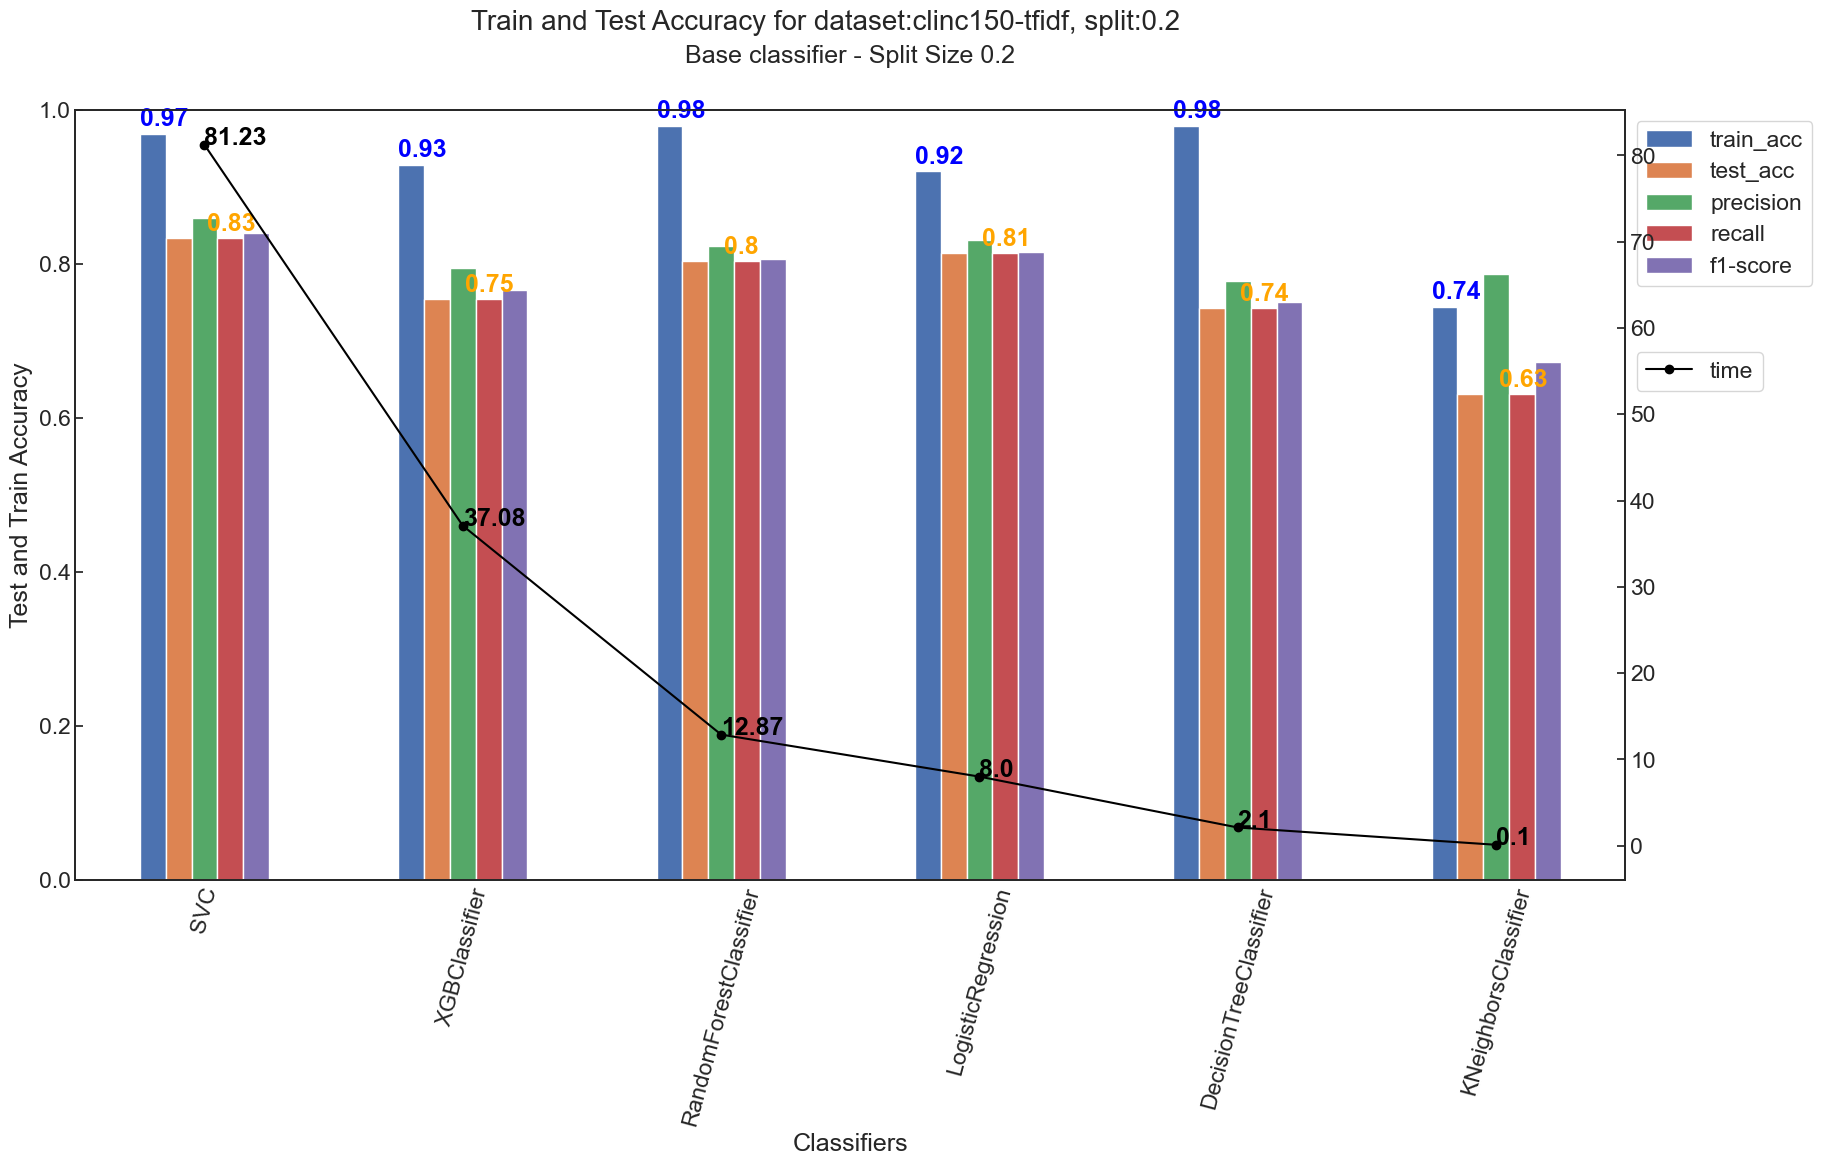

In [27]:
plotAccuracies(out_df, 0.2, 'No', 'clinc150-tfidf')

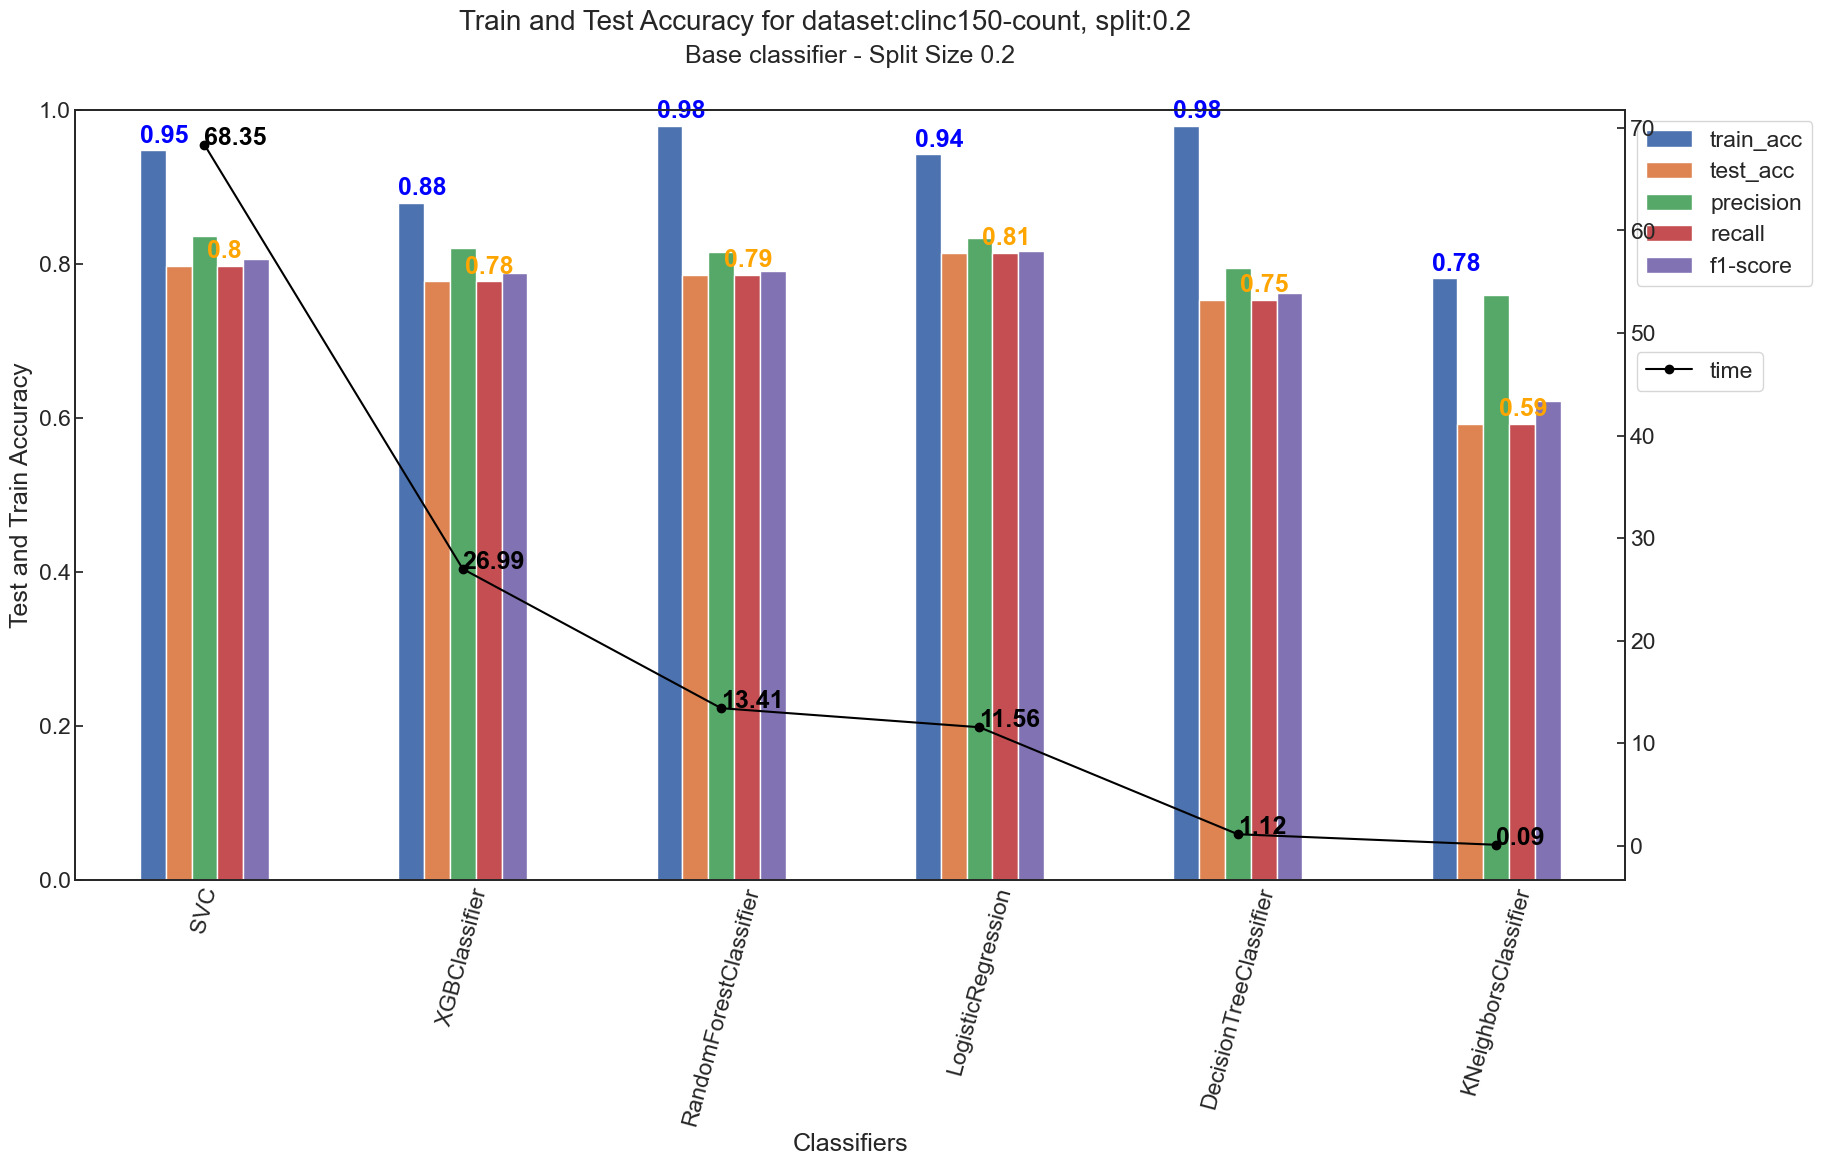

In [28]:
plotAccuracies(out_df, 0.2, 'No', 'clinc150-count')

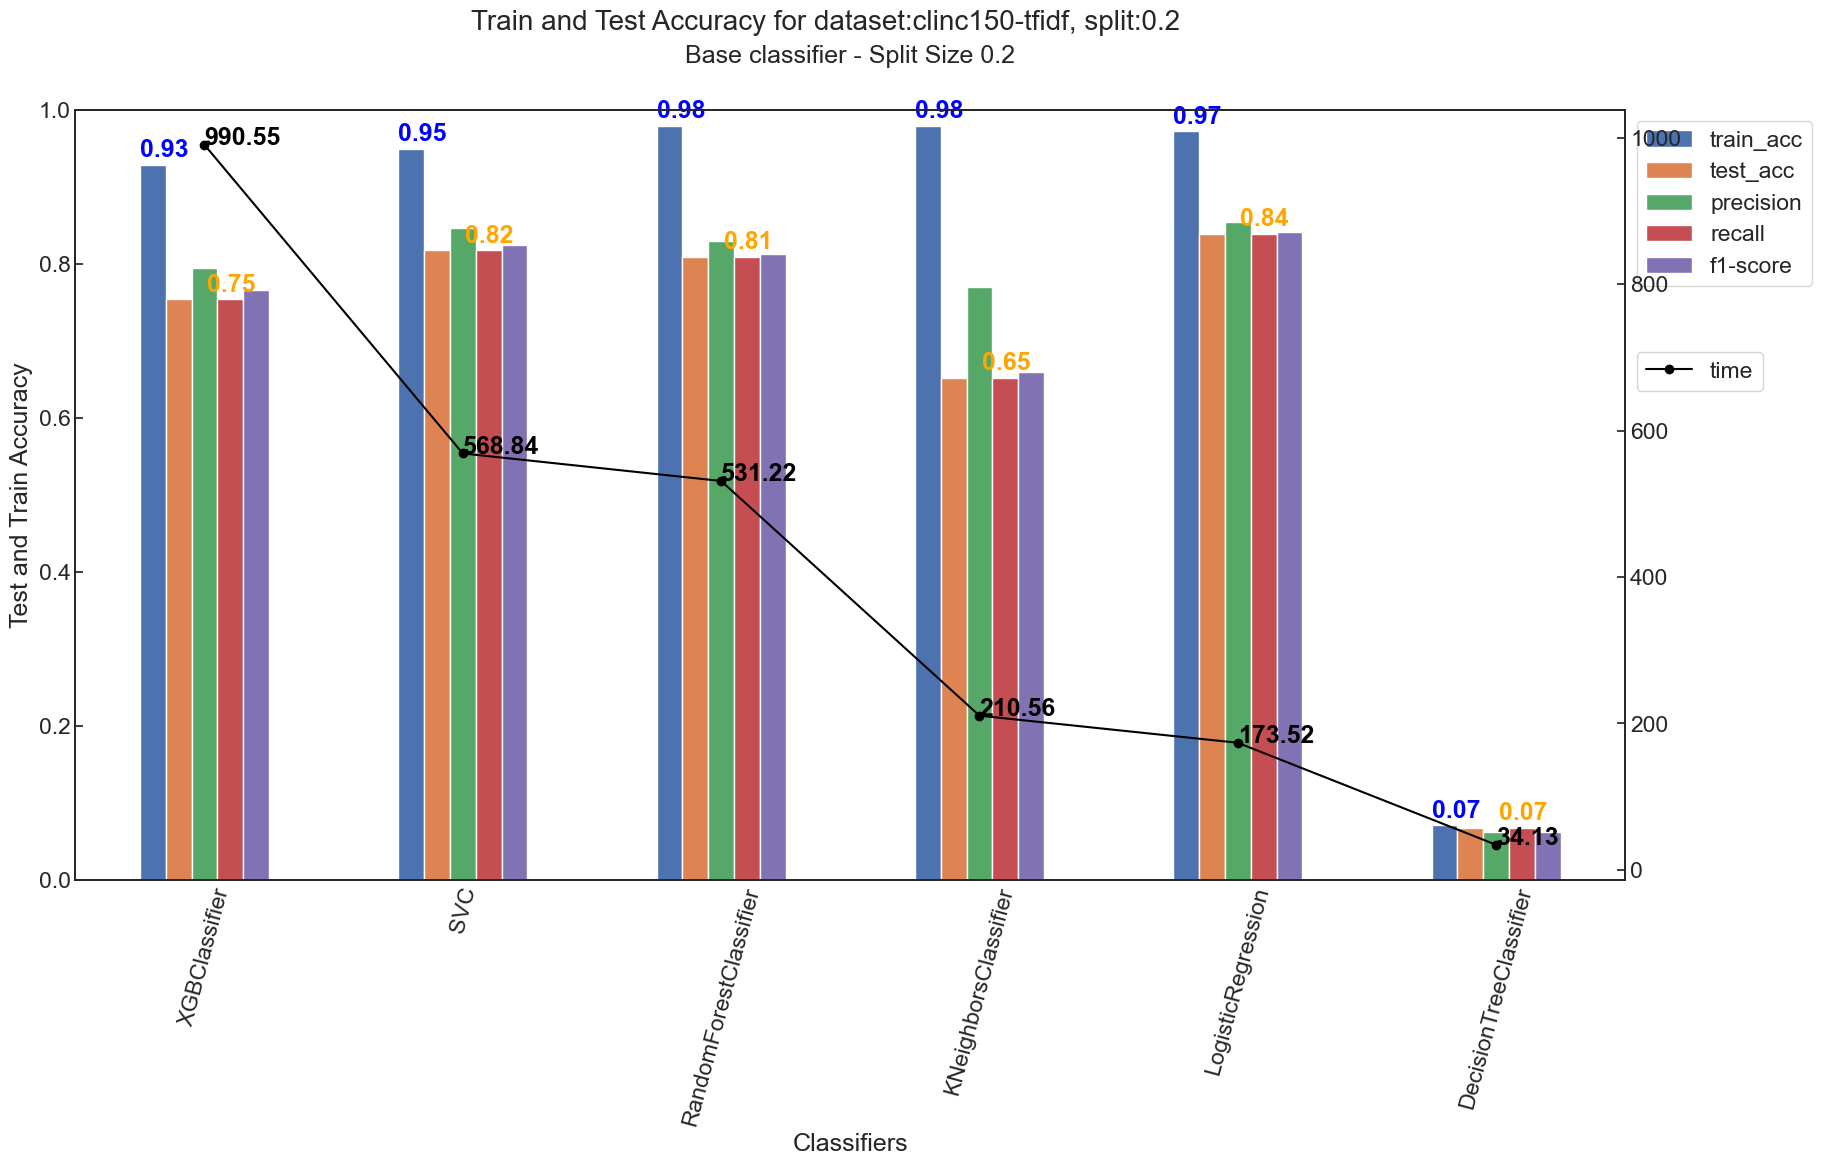

In [29]:
plotAccuracies(out_df, 0.2, 'halving', 'clinc150-tfidf')

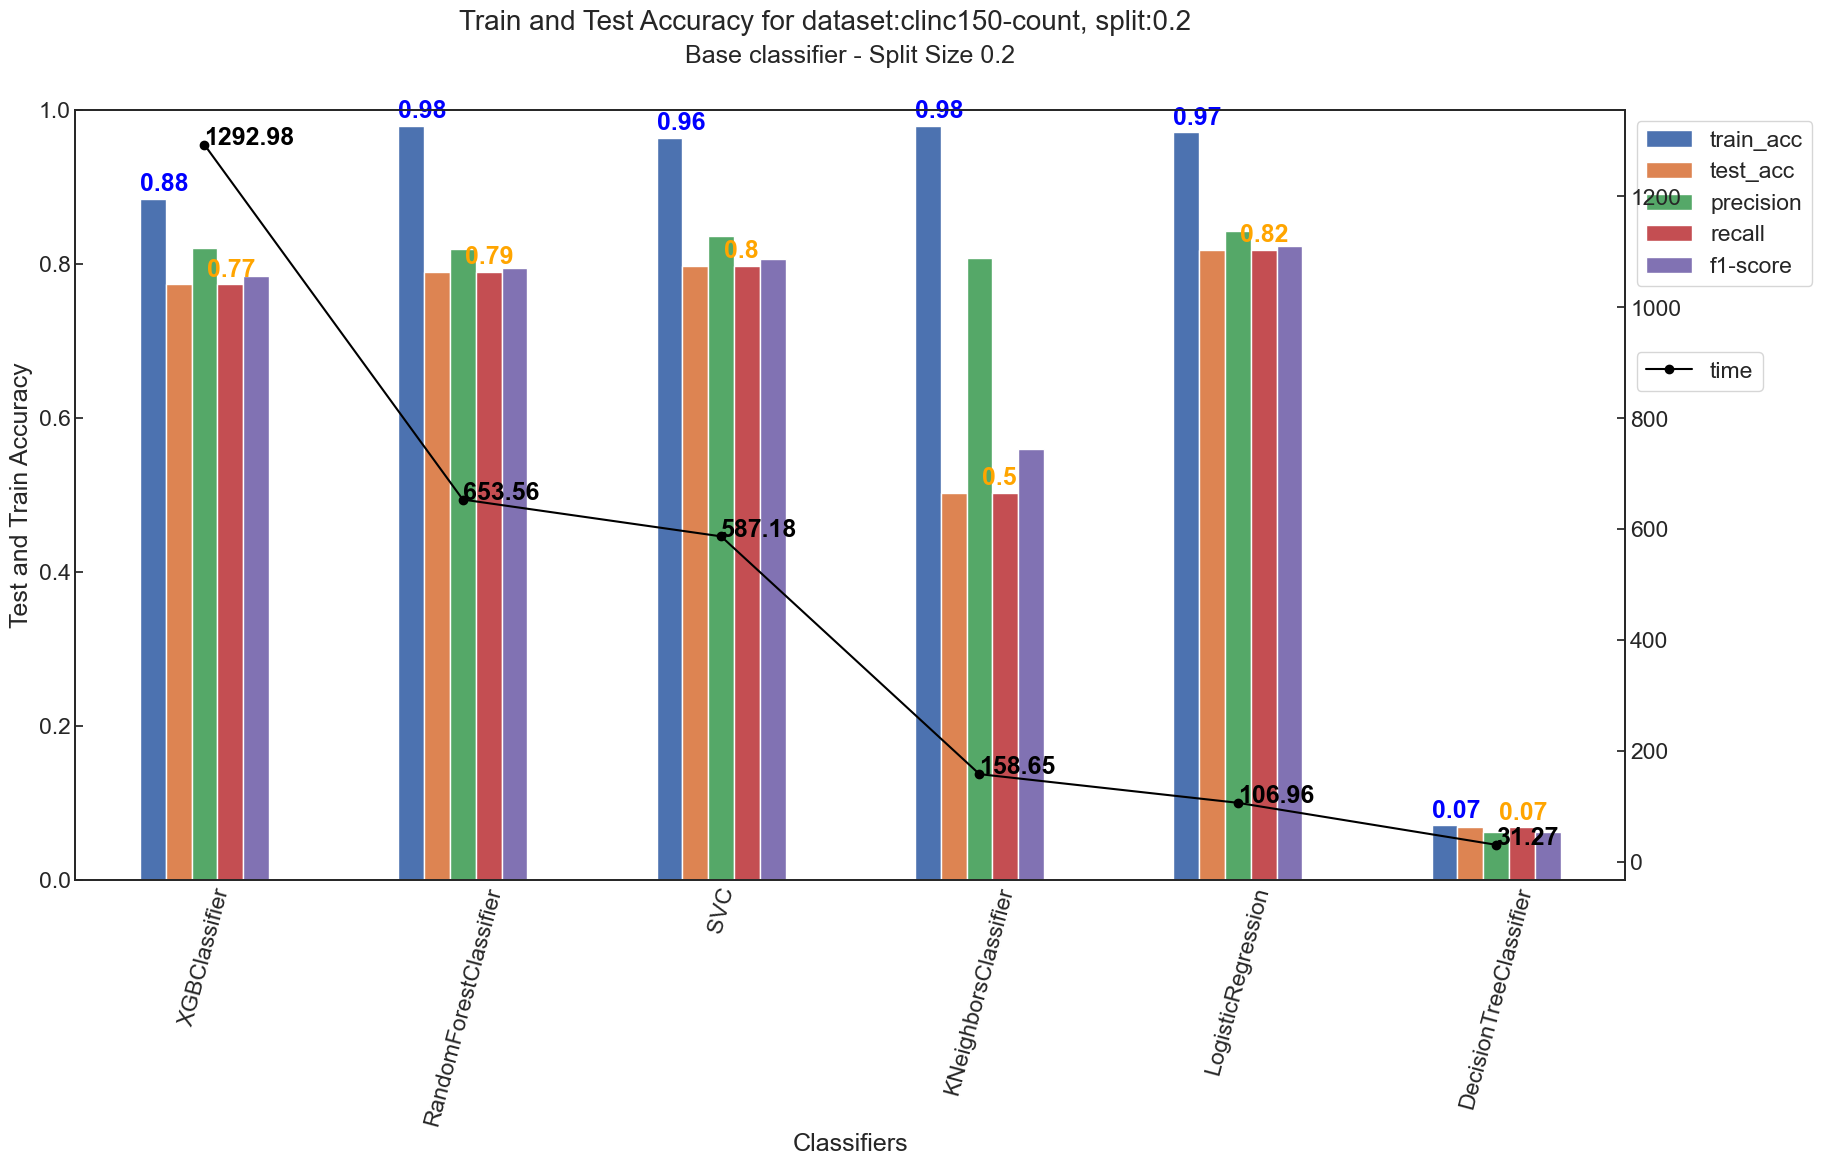

In [30]:
plotAccuracies(out_df, 0.2, 'halving', 'clinc150-count')

# 4.6 : model testing conclutions:
- Best model which could identify the intent is SVC with TFIDF Vecotorizer with accuracy of 0.83 accuracy on test set.
- mean precetion is 0.85 which is best compared to other classifiers.
- SVC is also the slowest model to train and test.
- LogisticRegression with Count Vectorizer is the second best model with accuracy of 0.82 on test set. Train accuracy = 0.94 and mean precision of 0.84 and very comparable to SVC with having upper hand on better time to fit and predict.
- KNeighborsClassifier is the fastest model to train and test but the train accuracy is 0.74, lowest among all.

# 5. Evaluation

Out of scope intent classification refers to the task of identifying when a user's input does not fall into any of the predefined intent categories. In other words, it involves detecting when a user's query is about a topic or task that the chatbot or NLU system is not trained to handle.

Out of scope detection is an important aspect of intent classification, as it allows the system to respond appropriately when it encounters inputs that it cannot handle. If the system does not have the ability to detect when an input is out of scope, it may provide irrelevant or inaccurate responses, which can result in a poor user experience.

To handle out of scope inputs, the system can either provide a generic response indicating that it does not understand the input, or it can try to redirect the user to an appropriate resource or provide a list of options for the user to choose from. In any case, being able to detect out of scope inputs is a critical component of an effective NLU system.

- Lets create dataframe which includes oos data in it.
- Create a new column `oos` which will be a boolean column with 1 for oos data and 0 for known data.

In [31]:
# X_train = df_train_oos[[TEXT_COLUMN]]
# y_train = df_train_oos[INTENT_COLUMN]

# X_test = df_test_oos[[TEXT_COLUMN]]
# y_test = df_test_oos[INTENT_COLUMN]

# X_val = df_val_oos[[TEXT_COLUMN]]
# y_val = df_val_oos[INTENT_COLUMN]

# validateClassifiers(preprocessor_tfidf, df_train, TEXT_COLUMN, INTENT_COLUMN, 'clinc150-tfidf-oos')
# validateClassifiers(preprocessor_count, df_train, TEXT_COLUMN, INTENT_COLUMN, 'clinc150-count-oos')

In [32]:
OOS_COLUMN = 'oos'
# merge df_train and df_train_oos
df_train_all = pd.concat([df_train, df_train_oos])
# create a new column to indicate if the intent is oos or not
df_train_all[OOS_COLUMN] = df_train_all[INTENT_COLUMN].apply(lambda x: 1 if x == OOS_COLUMN else 0)
print('train', df_train_all[OOS_COLUMN].value_counts())

# merge df_test and df_test_oos
df_test_all = pd.concat([df_test, df_test_oos])
# create a new column to indicate if the intent is oos or not
df_test_all[OOS_COLUMN] = df_test_all[INTENT_COLUMN].apply(lambda x: 1 if x == OOS_COLUMN else 0)
print('test', df_test_all[OOS_COLUMN].value_counts())

# merge df_val and df_val_oos
df_val_all = pd.concat([df_val, df_val_oos])
# create a new column to indicate if the intent is oos or not
df_val_all[OOS_COLUMN] = df_val_all[INTENT_COLUMN].apply(lambda x: 1 if x == OOS_COLUMN else 0)
print('val', df_val_all[OOS_COLUMN].value_counts())


train oos
0    15000
1      250
Name: count, dtype: int64
test oos
0    4500
1    1000
Name: count, dtype: int64
val oos
0    3000
1     100
Name: count, dtype: int64


In [33]:
# 5.1 create train, test, val sets
# # import train_valid_test_split
# from fast_ml.model_development import train_valid_test_split

X_train = df_train_all[[TEXT_COLUMN]]
y_train = df_train_all[OOS_COLUMN]

X_test = df_test_all[[TEXT_COLUMN]]
y_test = df_test_all[OOS_COLUMN]

X_val = df_val_all[[TEXT_COLUMN]]
y_val = df_val_all[OOS_COLUMN]


In [34]:
# 5.2 run a DummyClassifier for baseline

from sklearn.dummy import DummyClassifier
dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(X_train[TEXT_COLUMN], y_train)
y_pred = dummy_clf.predict(X_test[TEXT_COLUMN])
# print(classification_report(y_test, y_pred, target_names=le.classes_))
print(classification_report(y_test, y_pred))
# confusion matrix




              precision    recall  f1-score   support

           0       0.82      1.00      0.90      4500
           1       0.00      0.00      0.00      1000

    accuracy                           0.82      5500
   macro avg       0.41      0.50      0.45      5500
weighted avg       0.67      0.82      0.74      5500



# 5.2
- Dummy Classifier accuracy is 0.82. Anything above this is a good model.

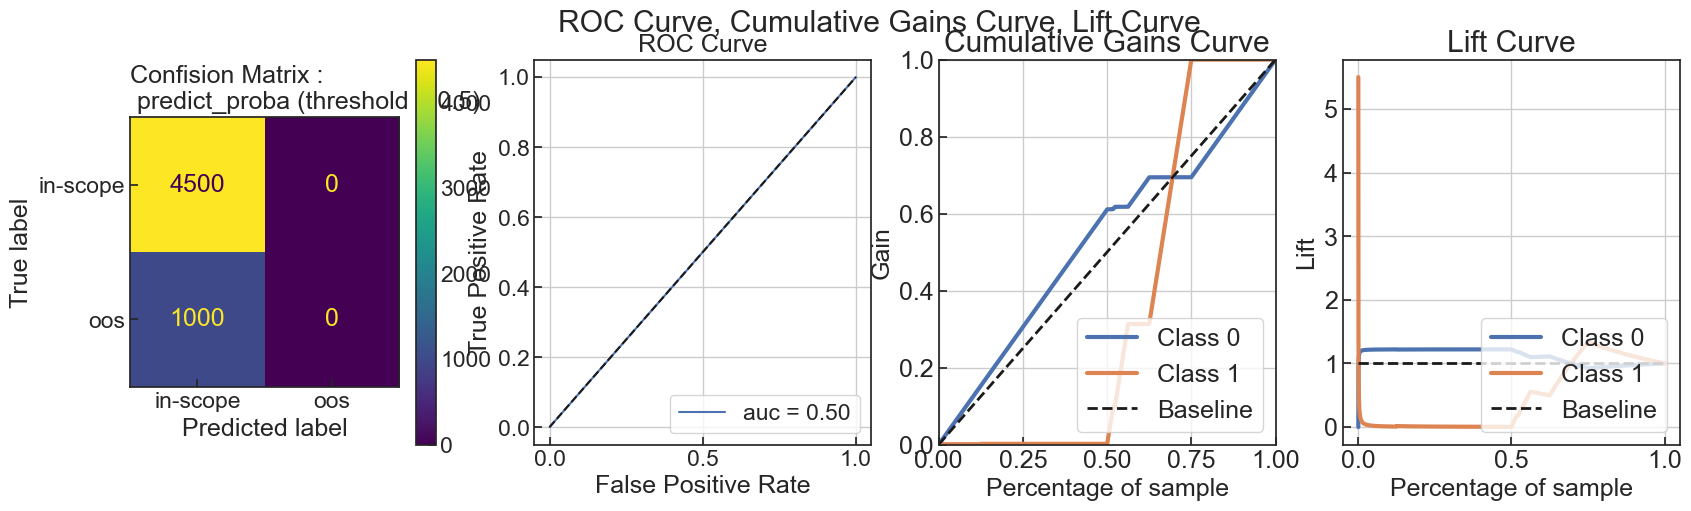

In [35]:
# check the Confusion Matrix, ROC Curve, Cumulative Gains Curve, Lift Curve for DummyClassifier
y_pred = dummy_clf.predict_proba(X_test[TEXT_COLUMN])
plotAll3(y_test, y_pred)

In [36]:
# 5.4 create a baseline model using LogisticRegression
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.fit_transform(y_test)
y_val = le.fit_transform(y_val)

model = make_pipeline(TfidfVectorizer(stop_words='english'), 
              LogisticRegression())
model.fit(X_train[TEXT_COLUMN], y_train)

Pipeline(steps=[('tfidfvectorizer', TfidfVectorizer(stop_words='english')),
                ('logisticregression', LogisticRegression())])

              precision    recall  f1-score   support

           0       0.82      1.00      0.90      4500
           1       0.00      0.00      0.00      1000

    accuracy                           0.82      5500
   macro avg       0.41      0.50      0.45      5500
weighted avg       0.67      0.82      0.74      5500



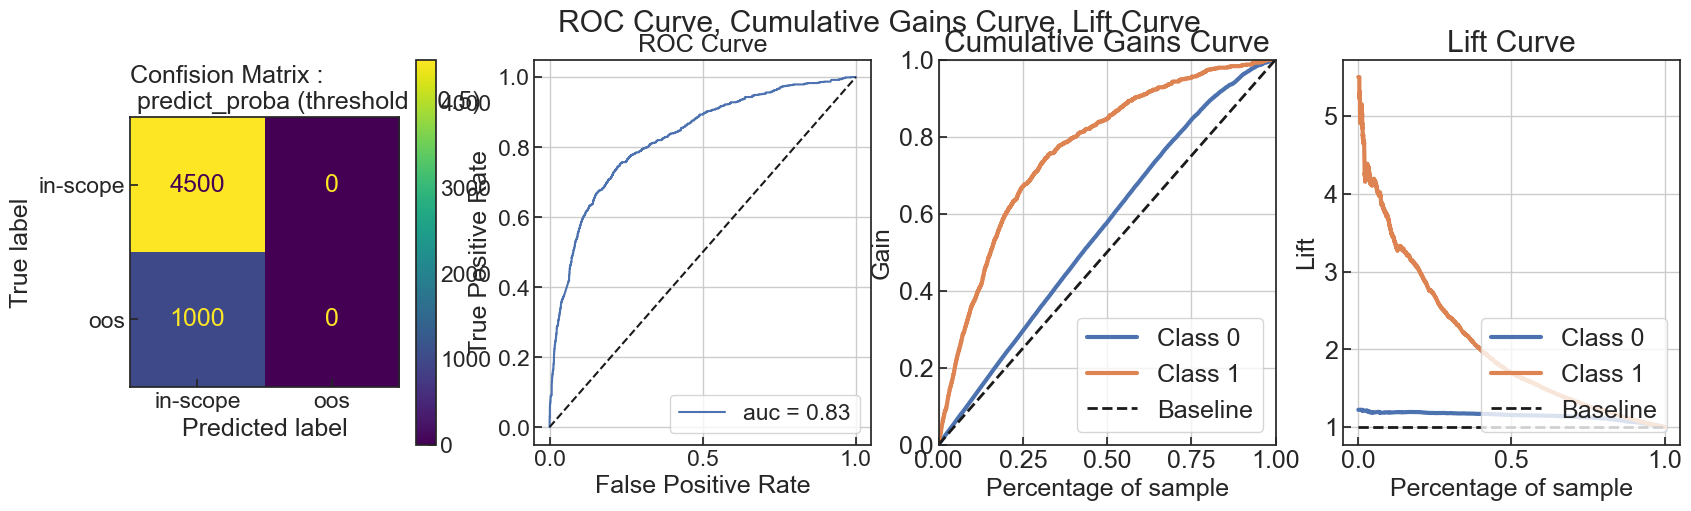

In [37]:

y_pred = model.predict(X_test[TEXT_COLUMN])

y_test = le.transform(y_test)
y_pred = le.transform(y_pred)
y_val = le.transform(y_val)


# print(classification_report(y_test, y_pred, target_names=list(map(str, le.classes_))))
print(classification_report(y_test, y_pred))
plotAll3(y_test, model.predict_proba(X_test[TEXT_COLUMN]))




# 5.3
- A basic LogisticRegression shows accuracy of 0.82 which is on par with dummy classifier.
- Lets try to improve this accuracy by using different models.

######## calcAcc_score DecisionTreeClassifier - clinc150-tfidf-oos start - Wed May 17 01:20:44 2023 ########
basic fit DecisionTreeClassifier timetaken: 0.8790597915649414
DecisionTreeClassifier       split :0.2 Train ACC: 1.0
DecisionTreeClassifier       split :0.2 Test ACC: 0.8276363636363636
DecisionTreeClassifier       split :0.2 Val ACC: 0.967741935483871
              precision    recall  f1-score   support

           0       0.83      0.99      0.90      4500
           1       0.72      0.08      0.15      1000

    accuracy                           0.83      5500
   macro avg       0.78      0.54      0.53      5500
weighted avg       0.81      0.83      0.77      5500



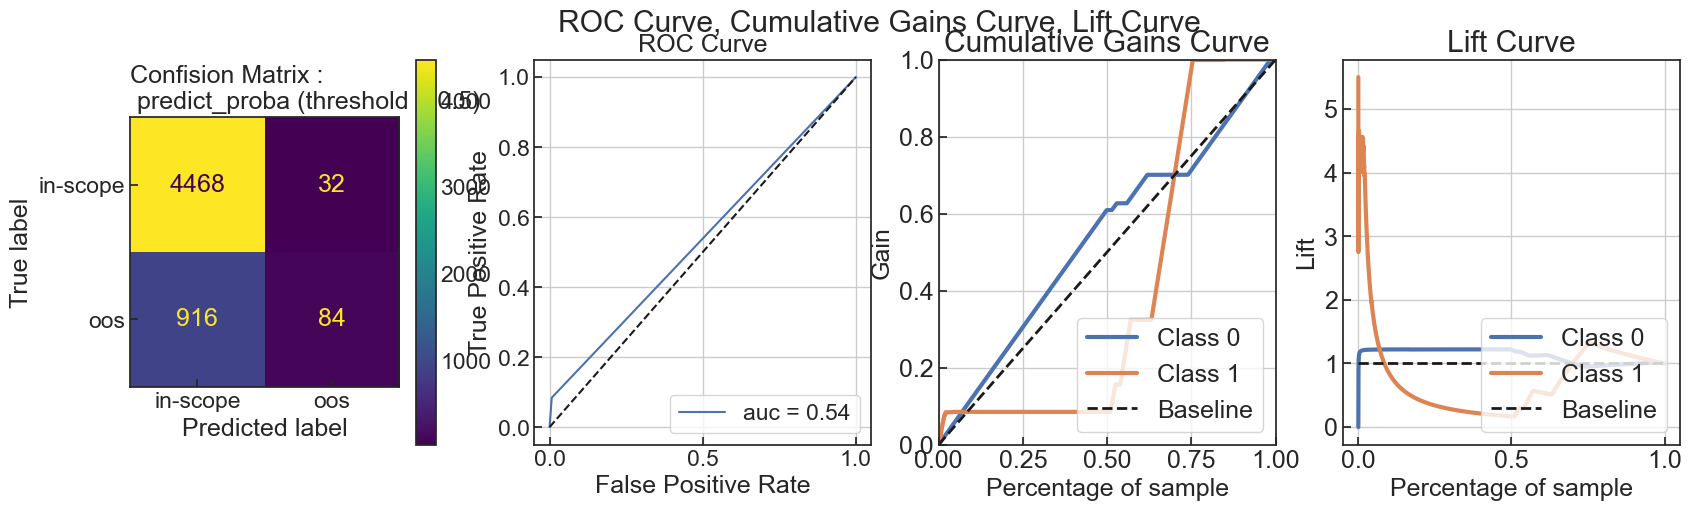

Time taken to run classification_report: 0.015523672103881836
n_iterations: 5
n_required_iterations: 5
n_possible_iterations: 5
min_resources_: 188
max_resources_: 15250
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 175
n_resources: 188
Fitting 5 folds for each of 175 candidates, totalling 875 fits
----------
iter: 1
n_candidates: 59
n_resources: 564
Fitting 5 folds for each of 59 candidates, totalling 295 fits
----------
iter: 2
n_candidates: 20
n_resources: 1692
Fitting 5 folds for each of 20 candidates, totalling 100 fits
----------
iter: 3
n_candidates: 7
n_resources: 5076
Fitting 5 folds for each of 7 candidates, totalling 35 fits
----------
iter: 4
n_candidates: 3
n_resources: 15228
Fitting 5 folds for each of 3 candidates, totalling 15 fits
DecisionTreeClassifier-grid  split :0.2 Train ACC: 0.9836065573770492, grid-fit timetaken: 12.11734127998352
DecisionTreeClassifier-grid  split :0.2 Test ACC: 0.8181818181818182
              precision    recall  f1

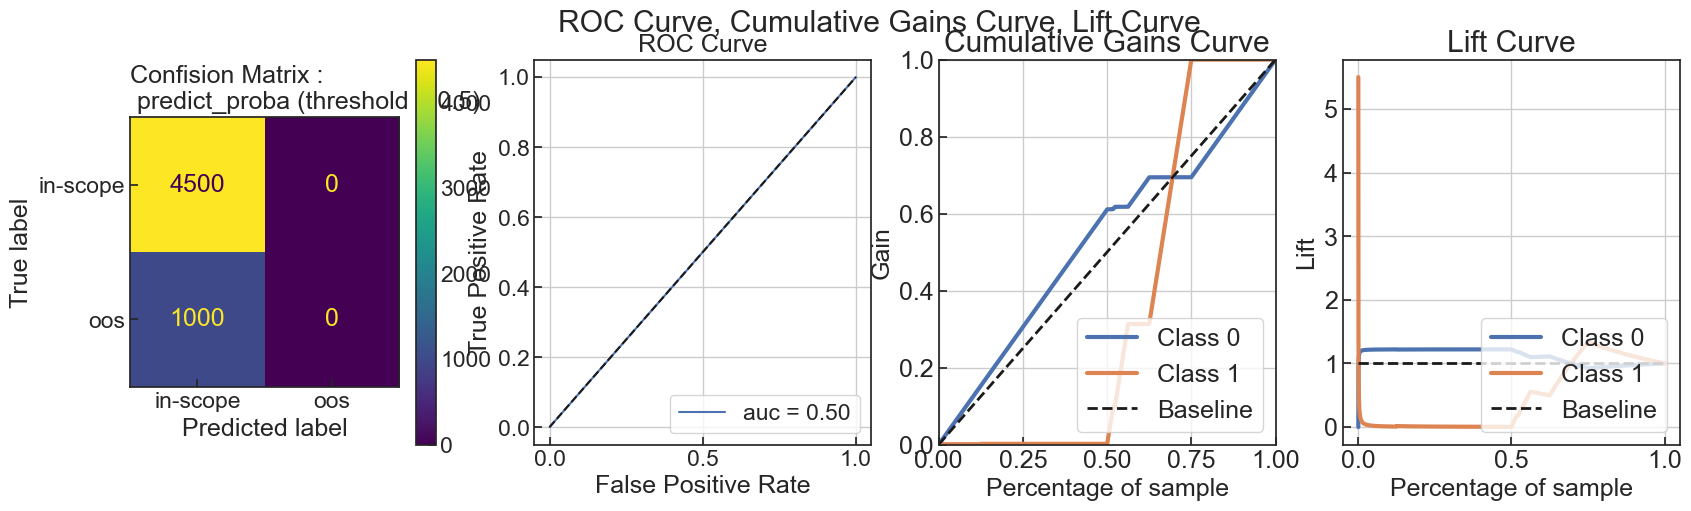

Time taken to run classification_report: 0.008962869644165039
DecisionTreeClassifier-grid  split :0.2 best params {'classifier__max_depth': 8, 'classifier__min_impurity_decrease': 1000.0, 'classifier__min_samples_split': 0.01}
accuracy: 0.8181818181818182
              precision    recall  f1-score  support
macro avg      0.409091  0.500000  0.450000   5500.0
weighted avg   0.669421  0.818182  0.736364   5500.0
######## calcAcc_score DecisionTreeClassifier end ########
######## calcAcc_score LogisticRegression - clinc150-tfidf-oos start - Wed May 17 01:20:59 2023 ########
basic fit LogisticRegression timetaken: 0.164139986038208
LogisticRegression       split :0.2 Train ACC: 0.9836065573770492
LogisticRegression       split :0.2 Test ACC: 0.8181818181818182
LogisticRegression       split :0.2 Val ACC: 0.967741935483871
              precision    recall  f1-score   support

           0       0.82      1.00      0.90      4500
           1       0.00      0.00      0.00      1000

    a

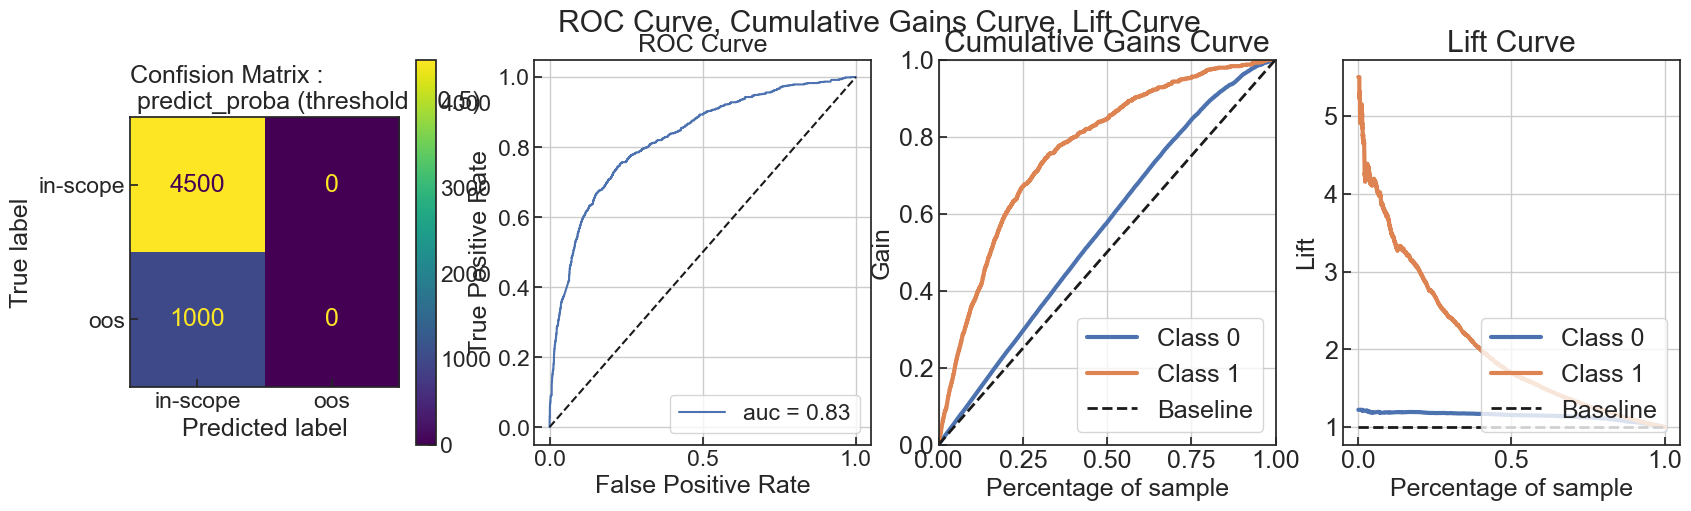

Time taken to run classification_report: 0.01305389404296875
n_iterations: 3
n_required_iterations: 3
n_possible_iterations: 3
min_resources_: 1694
max_resources_: 15250
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 12
n_resources: 1694
Fitting 5 folds for each of 12 candidates, totalling 60 fits
----------
iter: 1
n_candidates: 4
n_resources: 5082
Fitting 5 folds for each of 4 candidates, totalling 20 fits
----------
iter: 2
n_candidates: 2
n_resources: 15246
Fitting 5 folds for each of 2 candidates, totalling 10 fits
LogisticRegression-grid  split :0.2 Train ACC: 0.9836065573770492, grid-fit timetaken: 4.830871105194092
LogisticRegression-grid  split :0.2 Test ACC: 0.8181818181818182
              precision    recall  f1-score   support

           0       0.82      1.00      0.90      4500
           1       0.00      0.00      0.00      1000

    accuracy                           0.82      5500
   macro avg       0.41      0.50      0.45      5500
weight

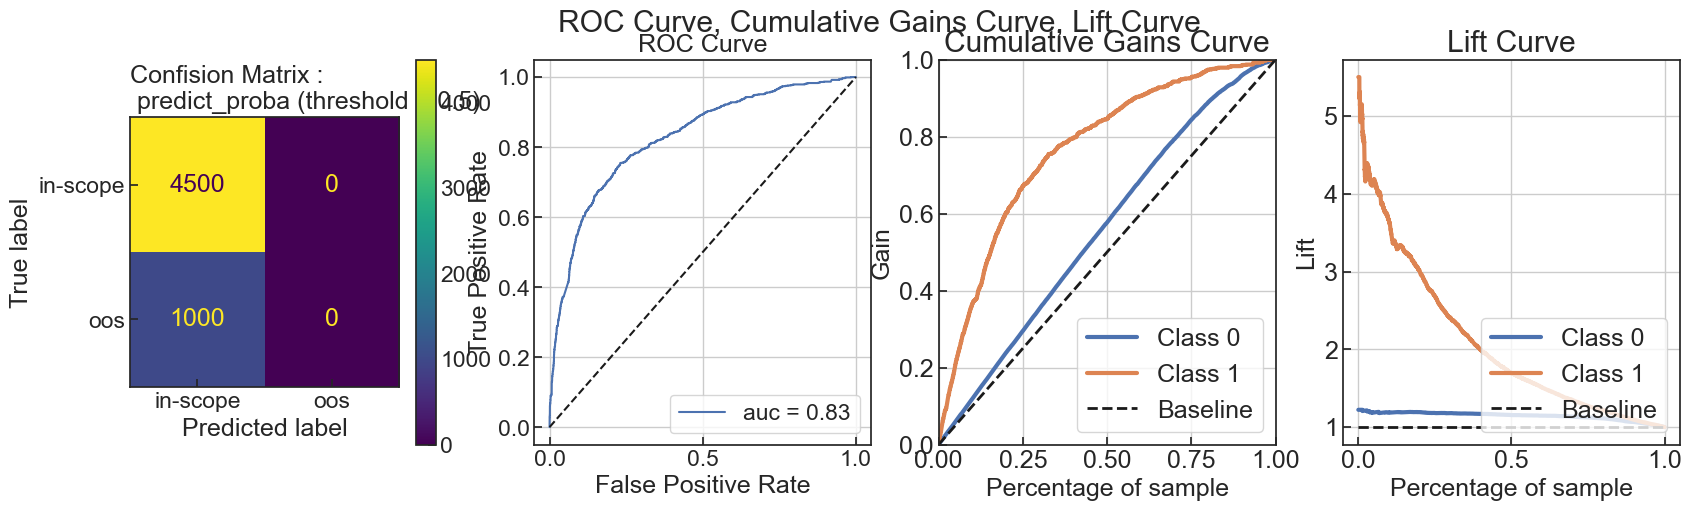

Time taken to run classification_report: 0.016368865966796875
LogisticRegression-grid  split :0.2 best params {'classifier__C': 1.0, 'classifier__max_iter': 100, 'classifier__penalty': 'l2', 'classifier__solver': 'liblinear'}
accuracy: 0.8181818181818182
              precision    recall  f1-score  support
macro avg      0.409091  0.500000  0.450000   5500.0
weighted avg   0.669421  0.818182  0.736364   5500.0
######## calcAcc_score LogisticRegression end ########
######## calcAcc_score KNeighborsClassifier - clinc150-tfidf-oos start - Wed May 17 01:21:07 2023 ########
basic fit KNeighborsClassifier timetaken: 0.12319684028625488
KNeighborsClassifier       split :0.2 Train ACC: 0.9839344262295082
KNeighborsClassifier       split :0.2 Test ACC: 0.8185454545454546
KNeighborsClassifier       split :0.2 Val ACC: 0.9683870967741935
              precision    recall  f1-score   support

           0       0.82      1.00      0.90      4500
           1       1.00      0.00      0.00      100

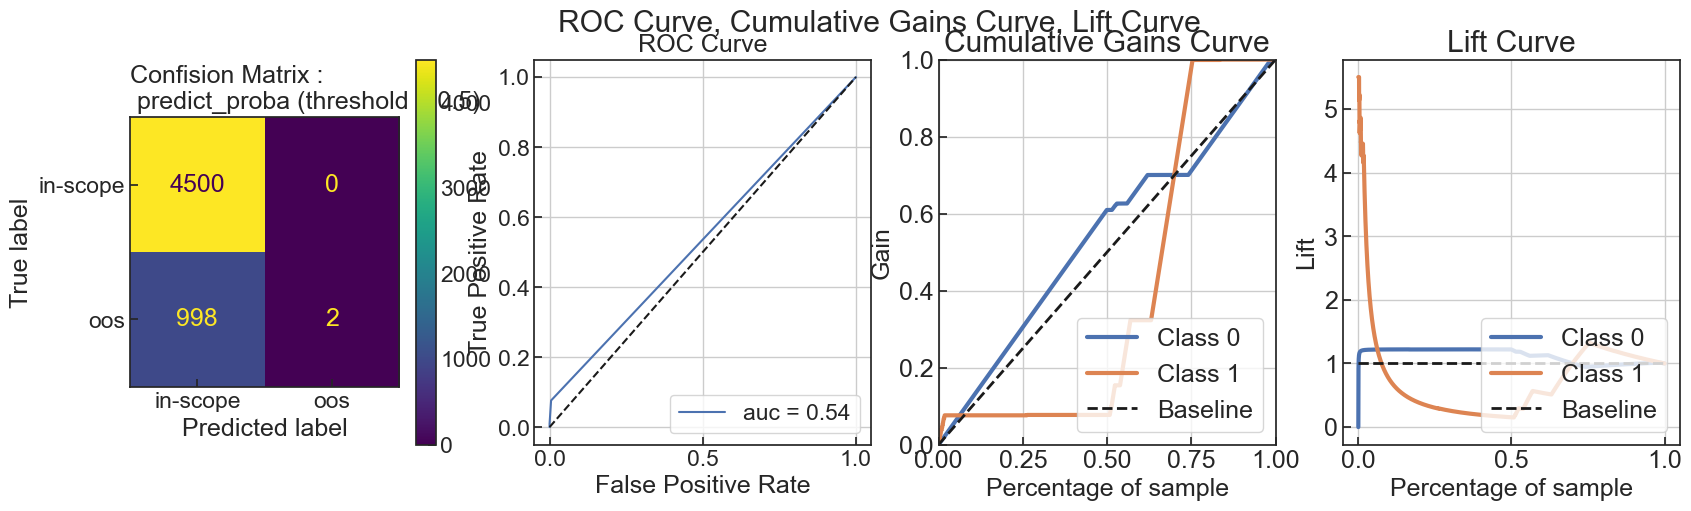

Time taken to run classification_report: 0.008093833923339844
n_iterations: 4
n_required_iterations: 4
n_possible_iterations: 4
min_resources_: 564
max_resources_: 15250
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 40
n_resources: 564
Fitting 5 folds for each of 40 candidates, totalling 200 fits
----------
iter: 1
n_candidates: 14
n_resources: 1692
Fitting 5 folds for each of 14 candidates, totalling 70 fits
----------
iter: 2
n_candidates: 5
n_resources: 5076
Fitting 5 folds for each of 5 candidates, totalling 25 fits
----------
iter: 3
n_candidates: 2
n_resources: 15228
Fitting 5 folds for each of 2 candidates, totalling 10 fits
KNeighborsClassifier-grid  split :0.2 Train ACC: 0.9836065573770492, grid-fit timetaken: 47.63682174682617
KNeighborsClassifier-grid  split :0.2 Test ACC: 0.8181818181818182
              precision    recall  f1-score   support

           0       0.82      1.00      0.90      4500
           1       0.00      0.00      0.00      1

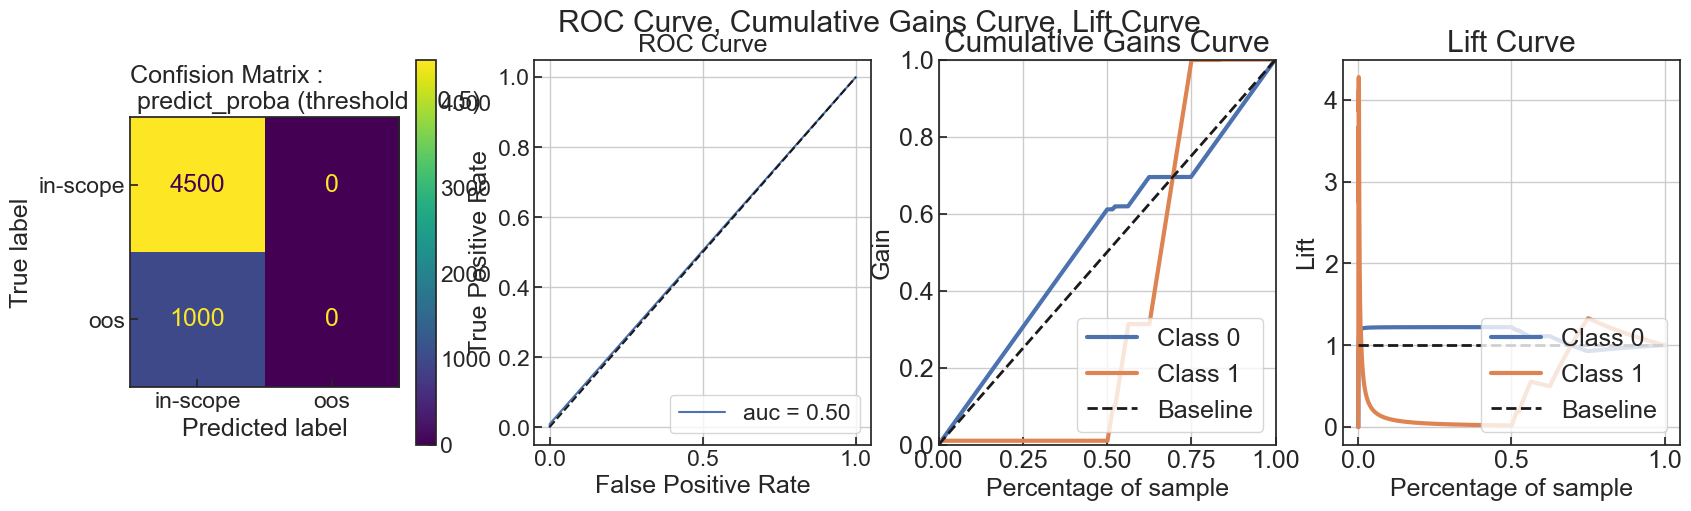

Time taken to run classification_report: 0.014658927917480469
KNeighborsClassifier-grid  split :0.2 best params {'classifier__metric': 'manhattan', 'classifier__n_neighbors': 100, 'classifier__weights': 'uniform'}
accuracy: 0.8181818181818182
              precision    recall  f1-score  support
macro avg      0.409091  0.500000  0.450000   5500.0
weighted avg   0.669421  0.818182  0.736364   5500.0
######## calcAcc_score KNeighborsClassifier end ########
######## calcAcc_score SVC - clinc150-tfidf-oos start - Wed May 17 01:22:20 2023 ########
basic fit SVC timetaken: 20.81085705757141
SVC       split :0.2 Train ACC: 0.9898360655737705
SVC       split :0.2 Test ACC: 0.8190909090909091
SVC       split :0.2 Val ACC: 0.967741935483871
              precision    recall  f1-score   support

           0       0.82      1.00      0.90      4500
           1       1.00      0.01      0.01      1000

    accuracy                           0.82      5500
   macro avg       0.91      0.50      0.

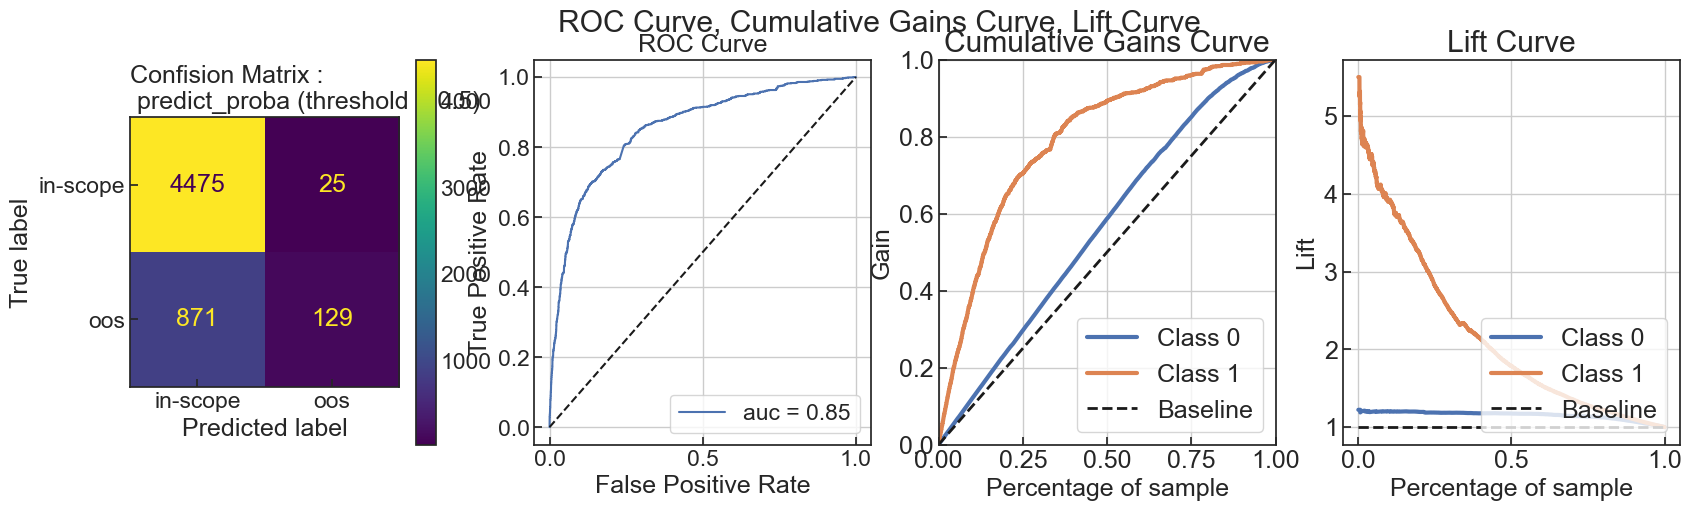

Time taken to run classification_report: 0.01761794090270996
n_iterations: 2
n_required_iterations: 2
n_possible_iterations: 2
min_resources_: 5083
max_resources_: 15250
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 4
n_resources: 5083
Fitting 5 folds for each of 4 candidates, totalling 20 fits
----------
iter: 1
n_candidates: 2
n_resources: 15249
Fitting 5 folds for each of 2 candidates, totalling 10 fits
SVC-grid  split :0.2 Train ACC: 0.9898360655737705, grid-fit timetaken: 86.12360095977783
SVC-grid  split :0.2 Test ACC: 0.8190909090909091
              precision    recall  f1-score   support

           0       0.82      1.00      0.90      4500
           1       1.00      0.01      0.01      1000

    accuracy                           0.82      5500
   macro avg       0.91      0.50      0.46      5500
weighted avg       0.85      0.82      0.74      5500



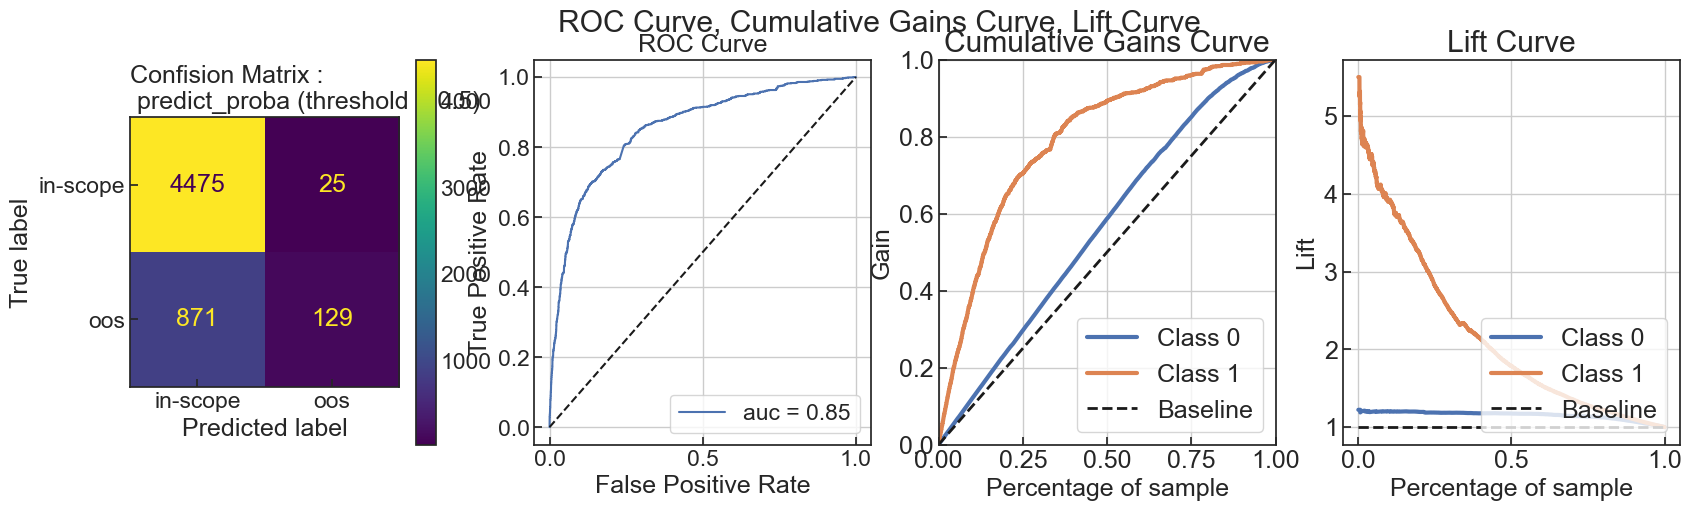

Time taken to run classification_report: 0.008426904678344727
SVC-grid  split :0.2 best params {'classifier__kernel': 'rbf'}
accuracy: 0.8190909090909091
              precision    recall  f1-score  support
macro avg      0.909463  0.502500  0.455200   5500.0
weighted avg   0.851849  0.819091  0.738541   5500.0
######## calcAcc_score SVC end ########
######## calcAcc_score RandomForestClassifier - clinc150-tfidf-oos start - Wed May 17 01:24:25 2023 ########
basic fit RandomForestClassifier timetaken: 2.3133809566497803
RandomForestClassifier       split :0.2 Train ACC: 0.9999344262295082
RandomForestClassifier       split :0.2 Test ACC: 0.8218181818181818
RandomForestClassifier       split :0.2 Val ACC: 0.967741935483871
              precision    recall  f1-score   support

           0       0.82      1.00      0.90      4500
           1       0.81      0.03      0.05      1000

    accuracy                           0.82      5500
   macro avg       0.82      0.51      0.48      55

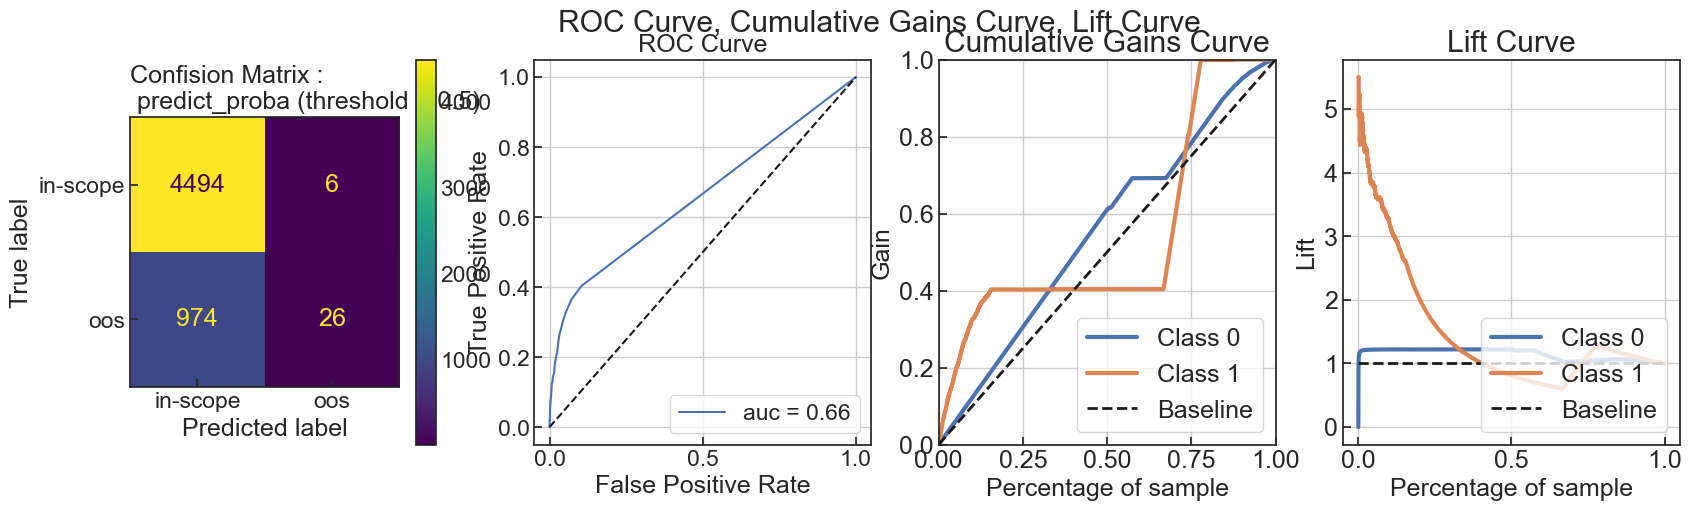

Time taken to run classification_report: 0.008501052856445312
n_iterations: 2
n_required_iterations: 2
n_possible_iterations: 2
min_resources_: 5083
max_resources_: 15250
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 6
n_resources: 5083
Fitting 5 folds for each of 6 candidates, totalling 30 fits
----------
iter: 1
n_candidates: 2
n_resources: 15249
Fitting 5 folds for each of 2 candidates, totalling 10 fits
RandomForestClassifier-grid  split :0.2 Train ACC: 1.0, grid-fit timetaken: 85.22332906723022
RandomForestClassifier-grid  split :0.2 Test ACC: 0.8218181818181818
              precision    recall  f1-score   support

           0       0.82      1.00      0.90      4500
           1       0.83      0.03      0.05      1000

    accuracy                           0.82      5500
   macro avg       0.83      0.51      0.48      5500
weighted avg       0.82      0.82      0.75      5500



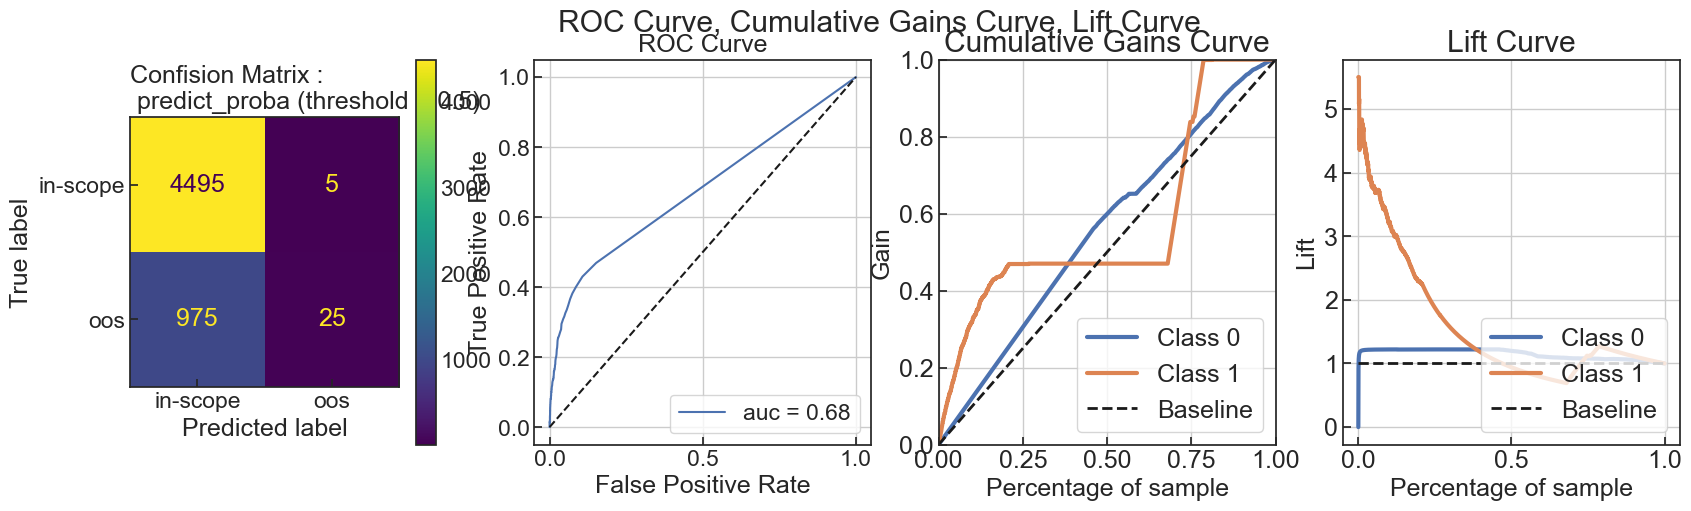

Time taken to run classification_report: 0.008595943450927734
RandomForestClassifier-grid  split :0.2 best params {'classifier__bootstrap': True, 'classifier__n_estimators': 300}
accuracy: 0.8218181818181818
              precision    recall  f1-score  support
macro avg      0.827544  0.511944  0.475124   5500.0
weighted avg   0.823860  0.821818  0.746585   5500.0
######## calcAcc_score RandomForestClassifier end ########
######## calcAcc_score XGBClassifier - clinc150-tfidf-oos start - Wed May 17 01:26:07 2023 ########
basic fit XGBClassifier timetaken: 0.5796689987182617
XGBClassifier       split :0.2 Train ACC: 0.9854426229508196
XGBClassifier       split :0.2 Test ACC: 0.8209090909090909
XGBClassifier       split :0.2 Val ACC: 0.9683870967741935
              precision    recall  f1-score   support

           0       0.82      1.00      0.90      4500
           1       0.94      0.02      0.03      1000

    accuracy                           0.82      5500
   macro avg       0.8

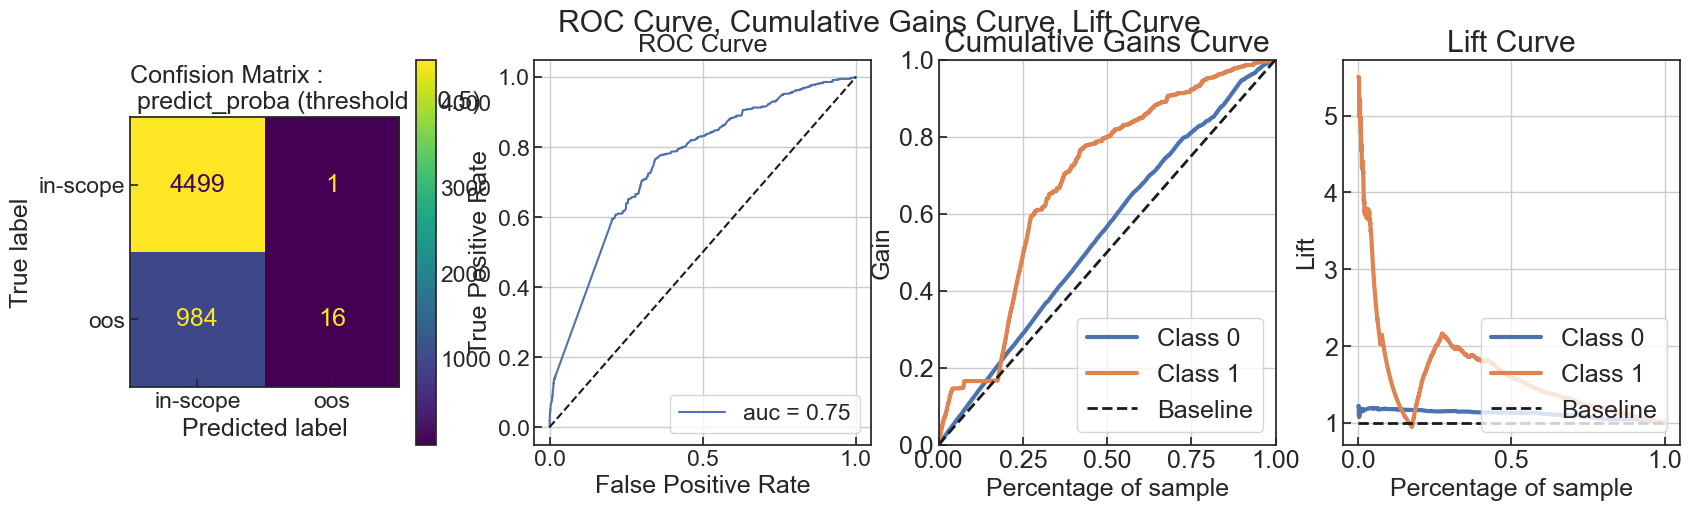

Time taken to run classification_report: 0.010625839233398438
n_iterations: 3
n_required_iterations: 3
n_possible_iterations: 3
min_resources_: 1694
max_resources_: 15250
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 9
n_resources: 1694
Fitting 5 folds for each of 9 candidates, totalling 45 fits
----------
iter: 1
n_candidates: 3
n_resources: 5082
Fitting 5 folds for each of 3 candidates, totalling 15 fits
----------
iter: 2
n_candidates: 1
n_resources: 15246
Fitting 5 folds for each of 1 candidates, totalling 5 fits
XGBClassifier-grid  split :0.2 Train ACC: 0.9862295081967213, grid-fit timetaken: 18.55404496192932
XGBClassifier-grid  split :0.2 Test ACC: 0.8214545454545454
              precision    recall  f1-score   support

           0       0.82      1.00      0.90      4500
           1       0.91      0.02      0.04      1000

    accuracy                           0.82      5500
   macro avg       0.87      0.51      0.47      5500
weighted avg      

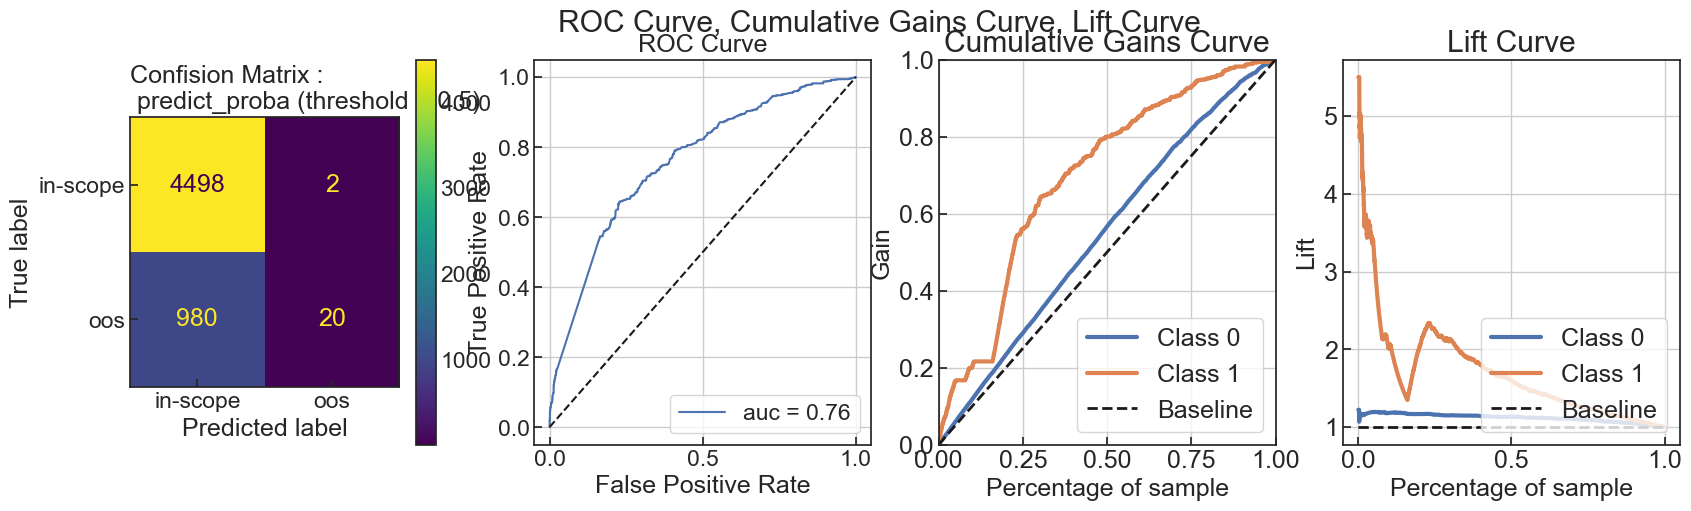

Time taken to run classification_report: 0.008514165878295898
XGBClassifier-grid  split :0.2 best params {'classifier__gamma': 0.3, 'classifier__n_estimators': 500}
accuracy: 0.8214545454545454
              precision    recall  f1-score  support
macro avg      0.865097  0.509778  0.470361   5500.0
weighted avg   0.837100  0.821455  0.744775   5500.0
######## calcAcc_score XGBClassifier end ########
######## calcAcc_score DecisionTreeClassifier - clinc150-count-oos start - Wed May 17 01:26:29 2023 ########
basic fit DecisionTreeClassifier timetaken: 0.4213120937347412
DecisionTreeClassifier       split :0.2 Train ACC: 1.0
DecisionTreeClassifier       split :0.2 Test ACC: 0.8269090909090909
DecisionTreeClassifier       split :0.2 Val ACC: 0.9635483870967742
              precision    recall  f1-score   support

           0       0.83      0.99      0.90      4500
           1       0.70      0.08      0.15      1000

    accuracy                           0.83      5500
   macro avg   

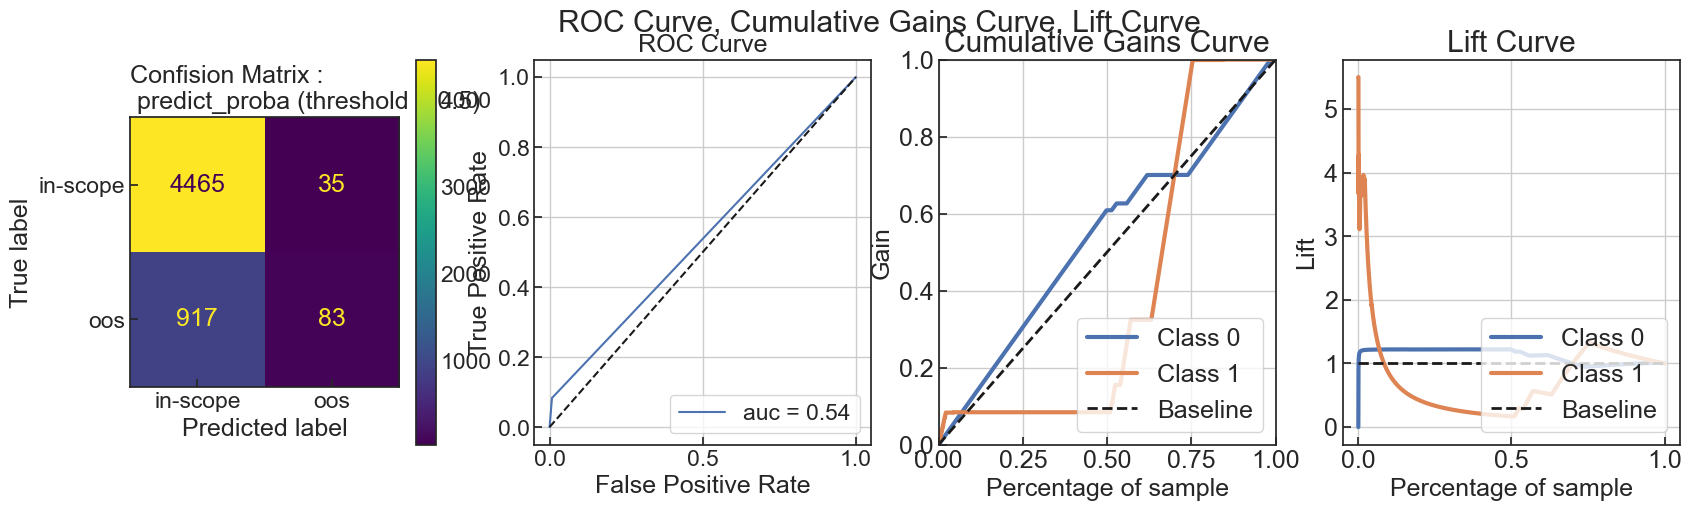

Time taken to run classification_report: 0.011459827423095703
n_iterations: 5
n_required_iterations: 5
n_possible_iterations: 5
min_resources_: 188
max_resources_: 15250
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 175
n_resources: 188
Fitting 5 folds for each of 175 candidates, totalling 875 fits
----------
iter: 1
n_candidates: 59
n_resources: 564
Fitting 5 folds for each of 59 candidates, totalling 295 fits
----------
iter: 2
n_candidates: 20
n_resources: 1692
Fitting 5 folds for each of 20 candidates, totalling 100 fits
----------
iter: 3
n_candidates: 7
n_resources: 5076
Fitting 5 folds for each of 7 candidates, totalling 35 fits
----------
iter: 4
n_candidates: 3
n_resources: 15228
Fitting 5 folds for each of 3 candidates, totalling 15 fits
DecisionTreeClassifier-grid  split :0.2 Train ACC: 0.9836065573770492, grid-fit timetaken: 11.435821771621704
DecisionTreeClassifier-grid  split :0.2 Test ACC: 0.8181818181818182
              precision    recall  f

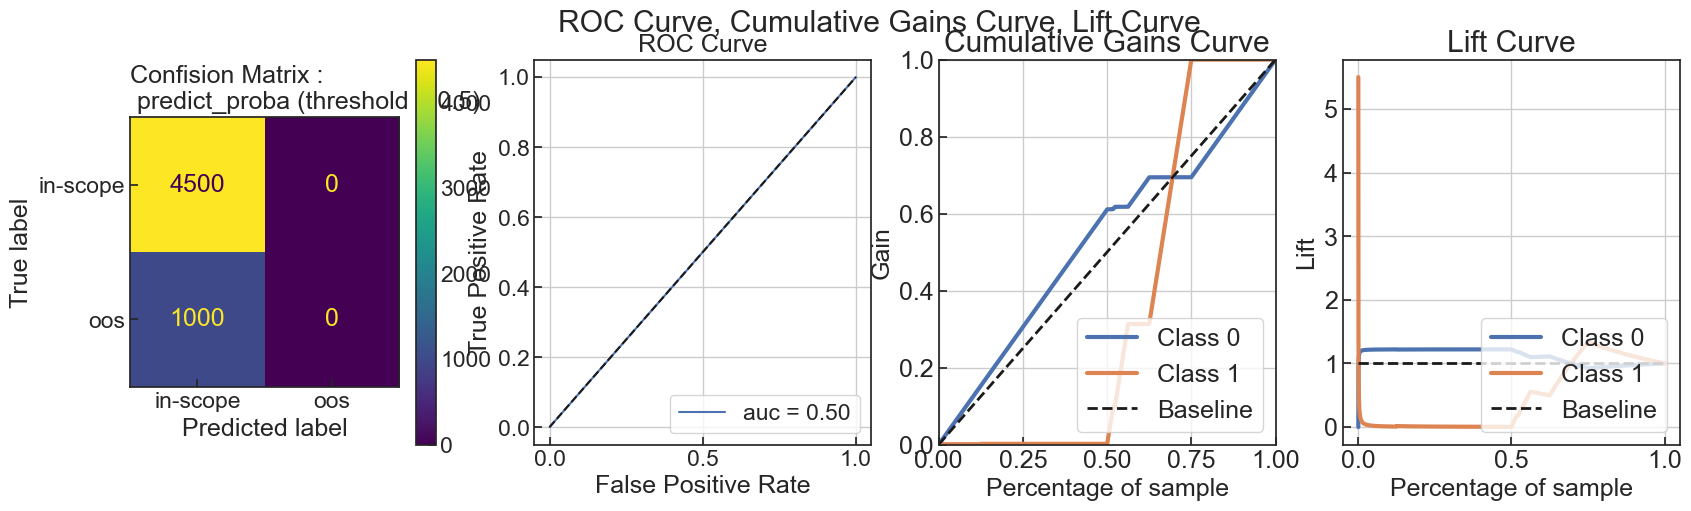

Time taken to run classification_report: 0.008533954620361328
DecisionTreeClassifier-grid  split :0.2 best params {'classifier__max_depth': 8, 'classifier__min_impurity_decrease': 1000.0, 'classifier__min_samples_split': 0.01}
accuracy: 0.8181818181818182
              precision    recall  f1-score  support
macro avg      0.409091  0.500000  0.450000   5500.0
weighted avg   0.669421  0.818182  0.736364   5500.0
######## calcAcc_score DecisionTreeClassifier end ########
######## calcAcc_score LogisticRegression - clinc150-count-oos start - Wed May 17 01:26:43 2023 ########
basic fit LogisticRegression timetaken: 0.16472887992858887
LogisticRegression       split :0.2 Train ACC: 0.9859672131147541
LogisticRegression       split :0.2 Test ACC: 0.8190909090909091
LogisticRegression       split :0.2 Val ACC: 0.9683870967741935
              precision    recall  f1-score   support

           0       0.82      1.00      0.90      4500
           1       1.00      0.01      0.01      1000

  

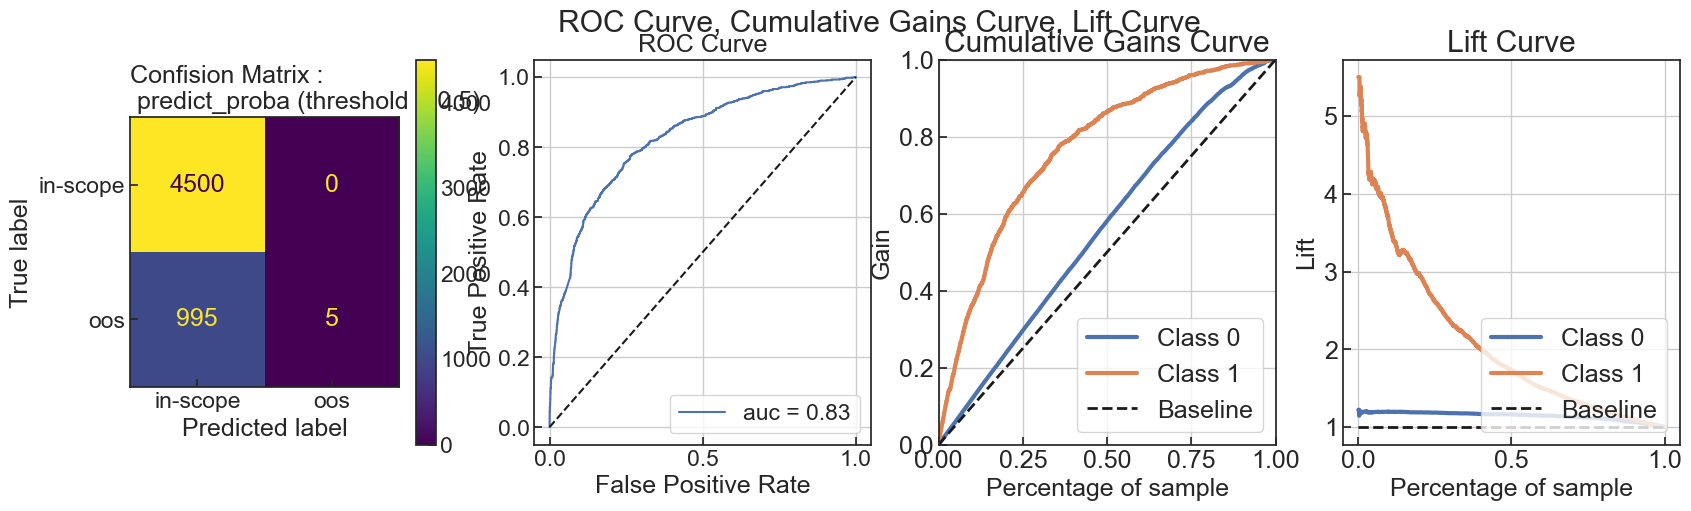

Time taken to run classification_report: 0.02073192596435547
n_iterations: 3
n_required_iterations: 3
n_possible_iterations: 3
min_resources_: 1694
max_resources_: 15250
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 12
n_resources: 1694
Fitting 5 folds for each of 12 candidates, totalling 60 fits
----------
iter: 1
n_candidates: 4
n_resources: 5082
Fitting 5 folds for each of 4 candidates, totalling 20 fits
----------
iter: 2
n_candidates: 2
n_resources: 15246
Fitting 5 folds for each of 2 candidates, totalling 10 fits
LogisticRegression-grid  split :0.2 Train ACC: 0.9864918032786886, grid-fit timetaken: 4.7813708782196045
LogisticRegression-grid  split :0.2 Test ACC: 0.8190909090909091
              precision    recall  f1-score   support

           0       0.82      1.00      0.90      4500
           1       1.00      0.01      0.01      1000

    accuracy                           0.82      5500
   macro avg       0.91      0.50      0.46      5500
weigh

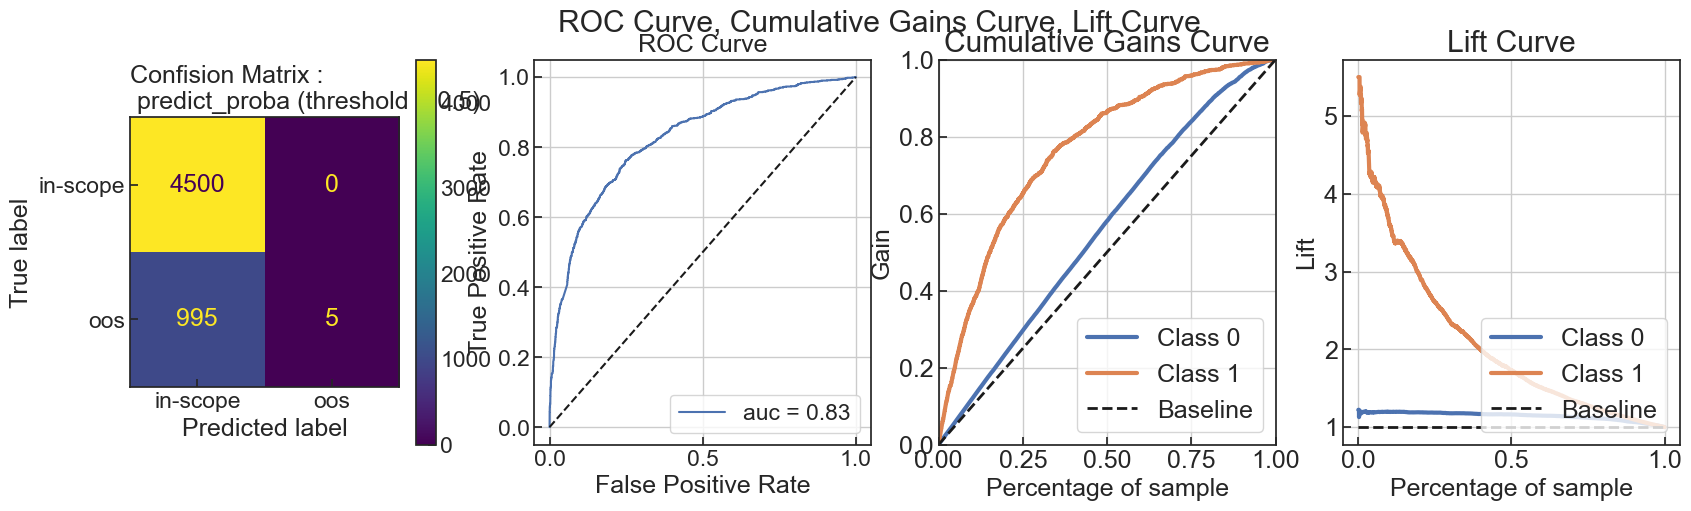

Time taken to run classification_report: 0.010687112808227539
LogisticRegression-grid  split :0.2 best params {'classifier__C': 1.0, 'classifier__max_iter': 100, 'classifier__penalty': 'l2', 'classifier__solver': 'saga'}
accuracy: 0.8190909090909091
              precision    recall  f1-score  support
macro avg      0.909463  0.502500  0.455200   5500.0
weighted avg   0.851849  0.819091  0.738541   5500.0
######## calcAcc_score LogisticRegression end ########
######## calcAcc_score KNeighborsClassifier - clinc150-count-oos start - Wed May 17 01:26:50 2023 ########
basic fit KNeighborsClassifier timetaken: 0.1107478141784668
KNeighborsClassifier       split :0.2 Train ACC: 0.9836721311475409
KNeighborsClassifier       split :0.2 Test ACC: 0.8181818181818182
KNeighborsClassifier       split :0.2 Val ACC: 0.967741935483871
              precision    recall  f1-score   support

           0       0.82      1.00      0.90      4500
           1       0.00      0.00      0.00      1000

    

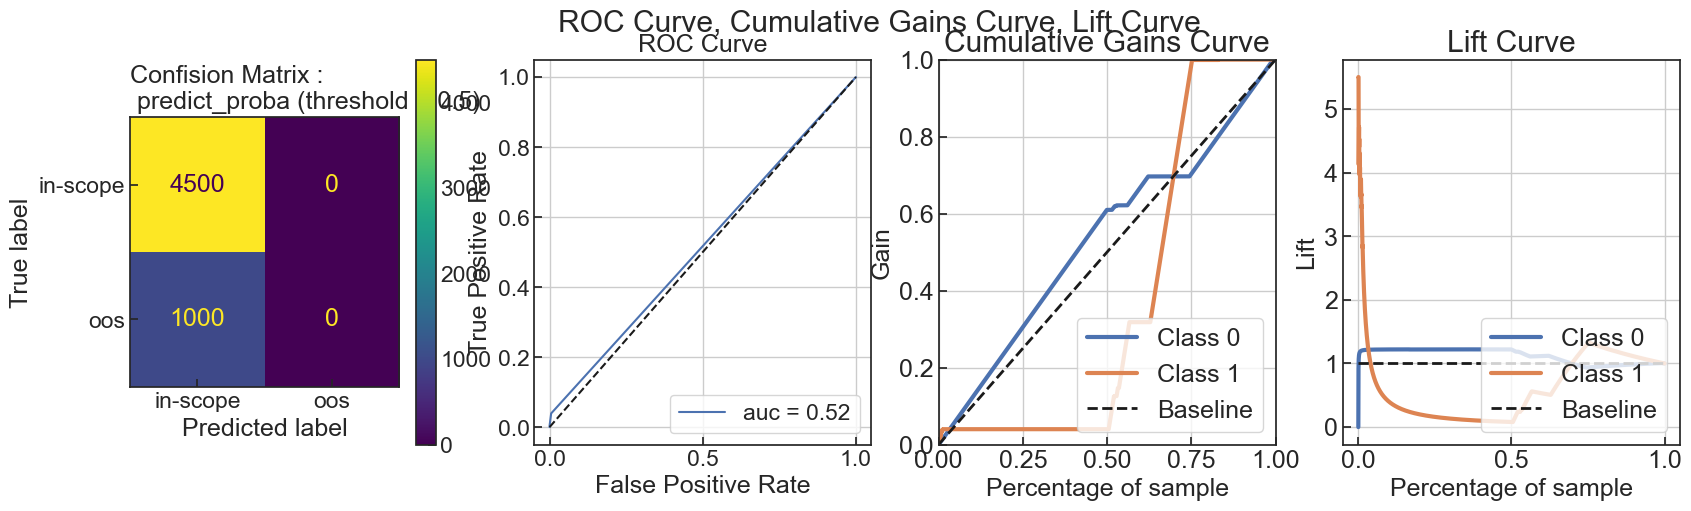

Time taken to run classification_report: 0.007884979248046875
n_iterations: 4
n_required_iterations: 4
n_possible_iterations: 4
min_resources_: 564
max_resources_: 15250
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 40
n_resources: 564
Fitting 5 folds for each of 40 candidates, totalling 200 fits
----------
iter: 1
n_candidates: 14
n_resources: 1692
Fitting 5 folds for each of 14 candidates, totalling 70 fits
----------
iter: 2
n_candidates: 5
n_resources: 5076
Fitting 5 folds for each of 5 candidates, totalling 25 fits
----------
iter: 3
n_candidates: 2
n_resources: 15228
Fitting 5 folds for each of 2 candidates, totalling 10 fits
KNeighborsClassifier-grid  split :0.2 Train ACC: 0.9836065573770492, grid-fit timetaken: 40.298128843307495
KNeighborsClassifier-grid  split :0.2 Test ACC: 0.8181818181818182
              precision    recall  f1-score   support

           0       0.82      1.00      0.90      4500
           1       0.00      0.00      0.00      

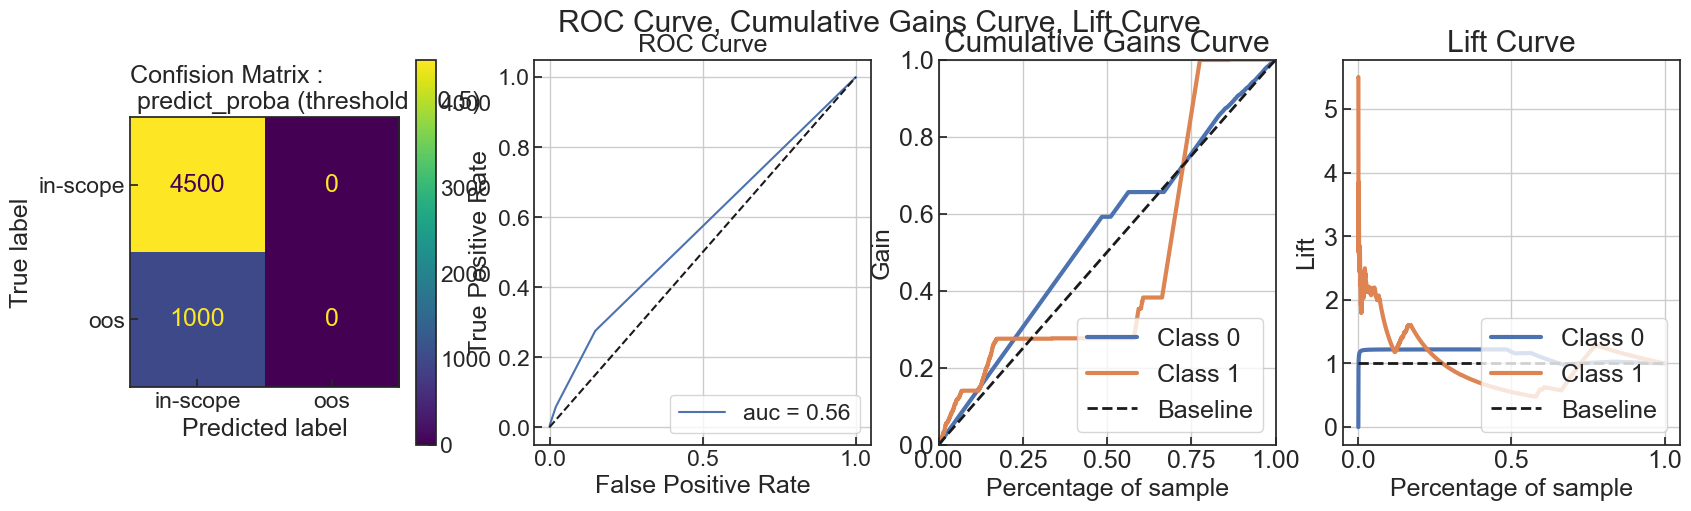

Time taken to run classification_report: 0.009699106216430664
KNeighborsClassifier-grid  split :0.2 best params {'classifier__metric': 'manhattan', 'classifier__n_neighbors': 100, 'classifier__weights': 'uniform'}
accuracy: 0.8181818181818182
              precision    recall  f1-score  support
macro avg      0.409091  0.500000  0.450000   5500.0
weighted avg   0.669421  0.818182  0.736364   5500.0
######## calcAcc_score KNeighborsClassifier end ########
######## calcAcc_score SVC - clinc150-count-oos start - Wed May 17 01:28:09 2023 ########
basic fit SVC timetaken: 19.324918746948242
SVC       split :0.2 Train ACC: 0.9889180327868853
SVC       split :0.2 Test ACC: 0.8181818181818182
SVC       split :0.2 Val ACC: 0.967741935483871
              precision    recall  f1-score   support

           0       0.82      1.00      0.90      4500
           1       0.00      0.00      0.00      1000

    accuracy                           0.82      5500
   macro avg       0.41      0.50      0

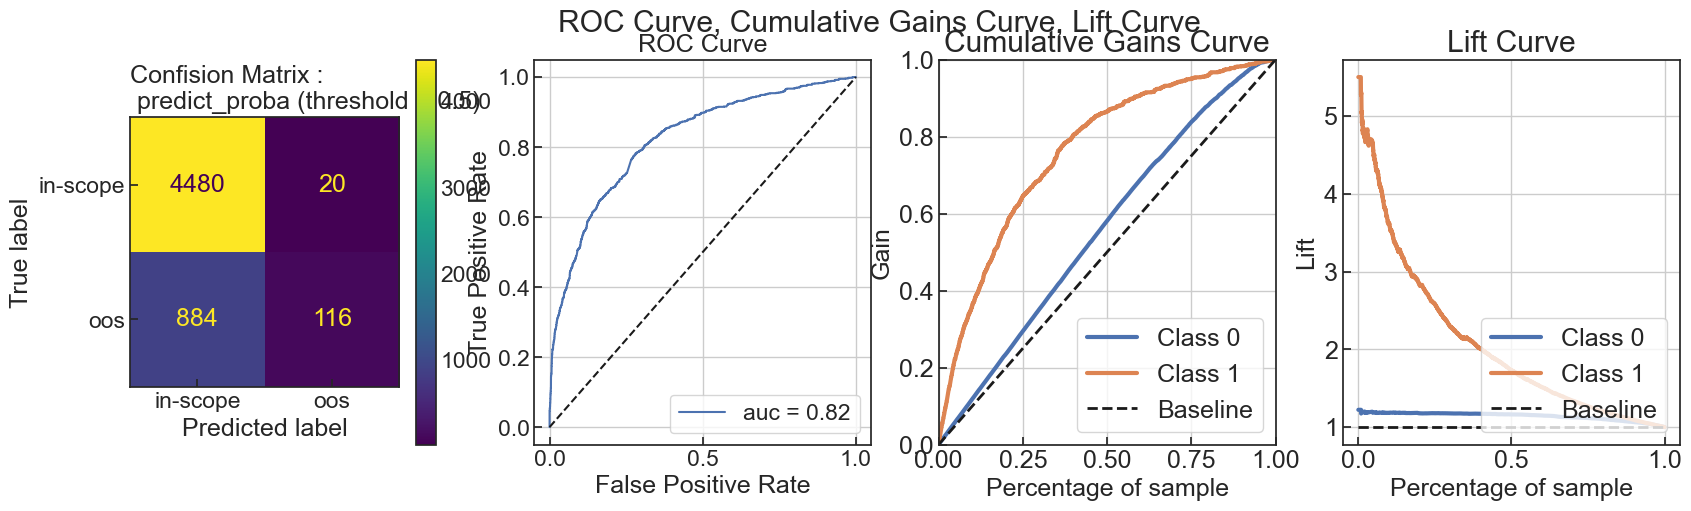

Time taken to run classification_report: 0.011527776718139648
n_iterations: 2
n_required_iterations: 2
n_possible_iterations: 2
min_resources_: 5083
max_resources_: 15250
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 4
n_resources: 5083
Fitting 5 folds for each of 4 candidates, totalling 20 fits
----------
iter: 1
n_candidates: 2
n_resources: 15249
Fitting 5 folds for each of 2 candidates, totalling 10 fits
SVC-grid  split :0.2 Train ACC: 0.9866229508196721, grid-fit timetaken: 58.90039110183716
SVC-grid  split :0.2 Test ACC: 0.8194545454545454
              precision    recall  f1-score   support

           0       0.82      1.00      0.90      4500
           1       1.00      0.01      0.01      1000

    accuracy                           0.82      5500
   macro avg       0.91      0.50      0.46      5500
weighted avg       0.85      0.82      0.74      5500



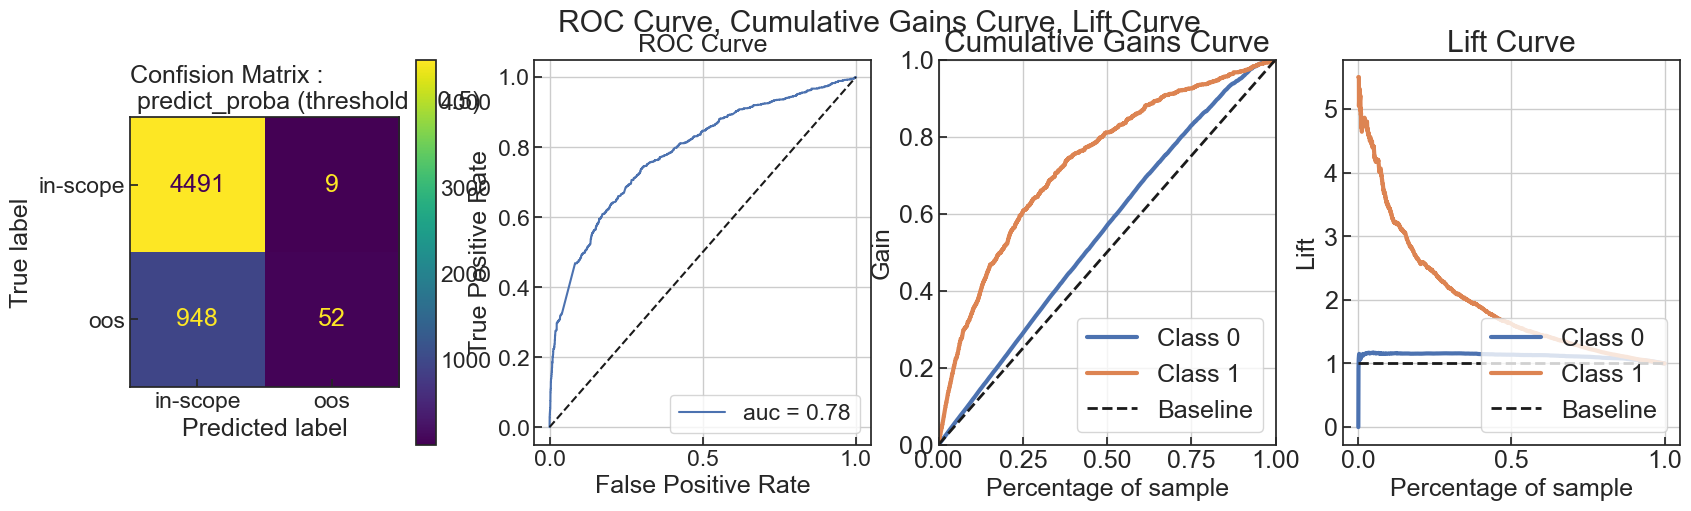

Time taken to run classification_report: 0.008040189743041992
SVC-grid  split :0.2 best params {'classifier__kernel': 'sigmoid'}
accuracy: 0.8194545454545454
              precision    recall  f1-score  support
macro avg      0.909612  0.503500  0.457267   5500.0
weighted avg   0.852093  0.819455  0.739407   5500.0
######## calcAcc_score SVC end ########
######## calcAcc_score RandomForestClassifier - clinc150-count-oos start - Wed May 17 01:29:39 2023 ########
basic fit RandomForestClassifier timetaken: 2.2949283123016357
RandomForestClassifier       split :0.2 Train ACC: 0.9999344262295082
RandomForestClassifier       split :0.2 Test ACC: 0.8234545454545454
RandomForestClassifier       split :0.2 Val ACC: 0.9687096774193549
              precision    recall  f1-score   support

           0       0.82      1.00      0.90      4500
           1       0.85      0.04      0.07      1000

    accuracy                           0.82      5500
   macro avg       0.84      0.52      0.48   

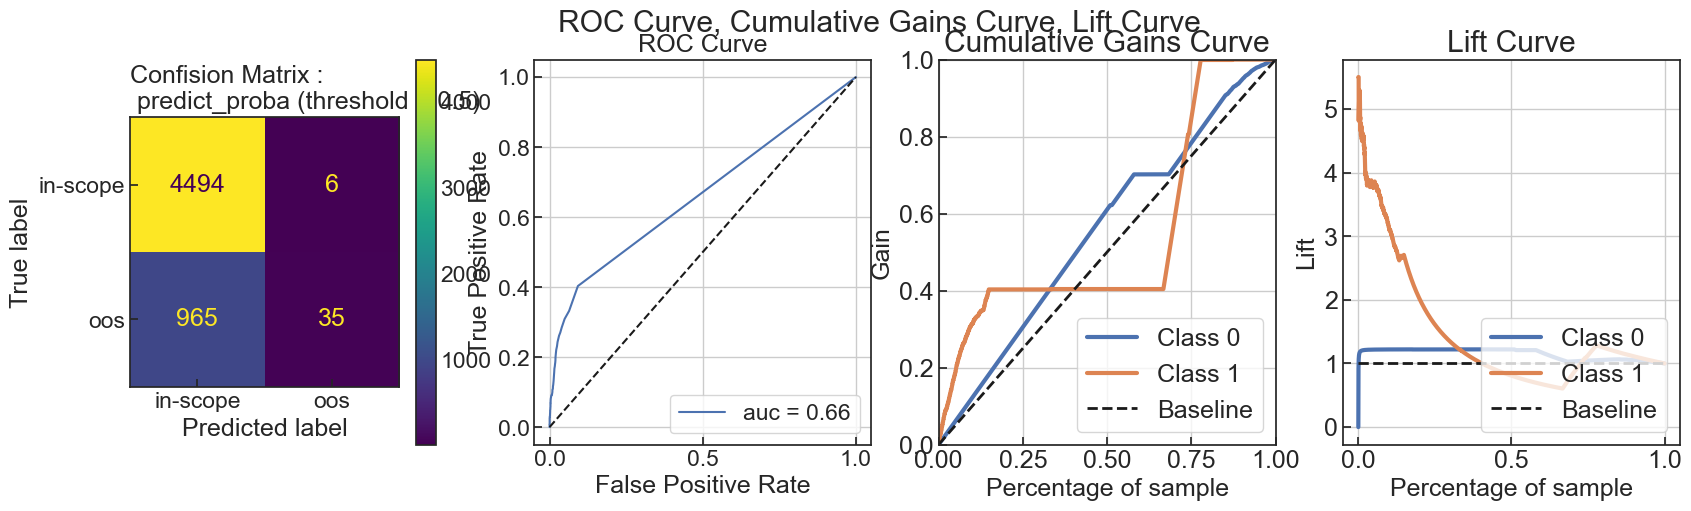

Time taken to run classification_report: 0.009418964385986328
n_iterations: 2
n_required_iterations: 2
n_possible_iterations: 2
min_resources_: 5083
max_resources_: 15250
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 6
n_resources: 5083
Fitting 5 folds for each of 6 candidates, totalling 30 fits
----------
iter: 1
n_candidates: 2
n_resources: 15249
Fitting 5 folds for each of 2 candidates, totalling 10 fits
RandomForestClassifier-grid  split :0.2 Train ACC: 1.0, grid-fit timetaken: 82.042160987854
RandomForestClassifier-grid  split :0.2 Test ACC: 0.822
              precision    recall  f1-score   support

           0       0.82      1.00      0.90      4500
           1       0.82      0.03      0.05      1000

    accuracy                           0.82      5500
   macro avg       0.82      0.51      0.48      5500
weighted avg       0.82      0.82      0.75      5500



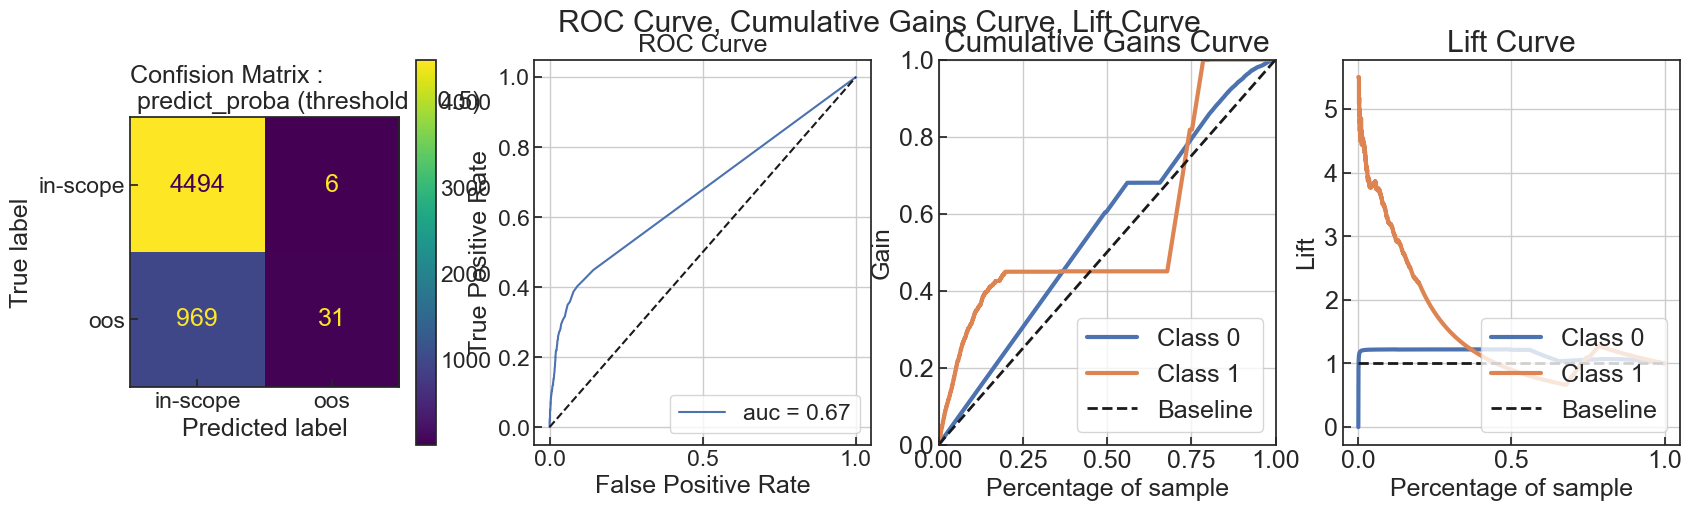

Time taken to run classification_report: 0.011251211166381836
RandomForestClassifier-grid  split :0.2 best params {'classifier__bootstrap': True, 'classifier__n_estimators': 300}
accuracy: 0.822
              precision    recall  f1-score  support
macro avg      0.820102  0.512833  0.477025   5500.0
weighted avg   0.821325  0.822000  0.747321   5500.0
######## calcAcc_score RandomForestClassifier end ########
######## calcAcc_score XGBClassifier - clinc150-count-oos start - Wed May 17 01:31:18 2023 ########
basic fit XGBClassifier timetaken: 0.28932714462280273
XGBClassifier       split :0.2 Train ACC: 0.9847213114754099
XGBClassifier       split :0.2 Test ACC: 0.8212727272727273
XGBClassifier       split :0.2 Val ACC: 0.9687096774193549
              precision    recall  f1-score   support

           0       0.82      1.00      0.90      4500
           1       1.00      0.02      0.03      1000

    accuracy                           0.82      5500
   macro avg       0.91      0.51 

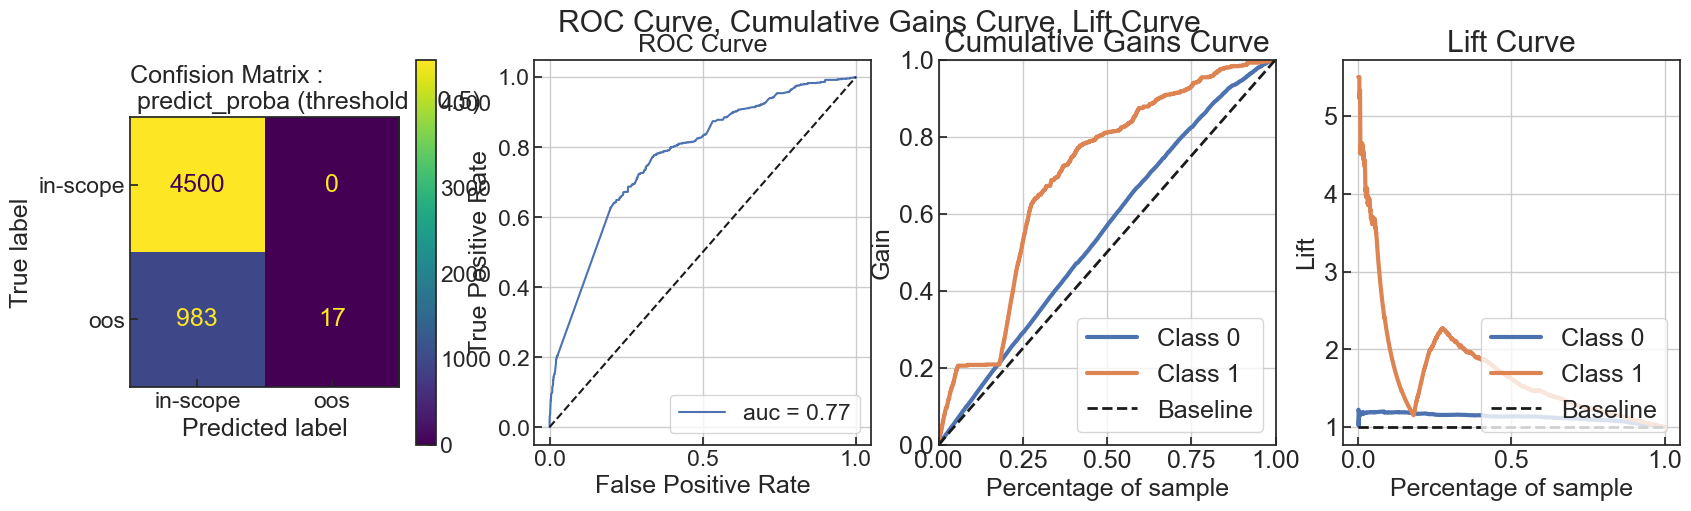

Time taken to run classification_report: 0.008162975311279297
n_iterations: 3
n_required_iterations: 3
n_possible_iterations: 3
min_resources_: 1694
max_resources_: 15250
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 9
n_resources: 1694
Fitting 5 folds for each of 9 candidates, totalling 45 fits
----------
iter: 1
n_candidates: 3
n_resources: 5082
Fitting 5 folds for each of 3 candidates, totalling 15 fits
----------
iter: 2
n_candidates: 1
n_resources: 15246
Fitting 5 folds for each of 1 candidates, totalling 5 fits
XGBClassifier-grid  split :0.2 Train ACC: 0.9847213114754099, grid-fit timetaken: 13.631875038146973
XGBClassifier-grid  split :0.2 Test ACC: 0.8212727272727273
              precision    recall  f1-score   support

           0       0.82      1.00      0.90      4500
           1       1.00      0.02      0.03      1000

    accuracy                           0.82      5500
   macro avg       0.91      0.51      0.47      5500
weighted avg     

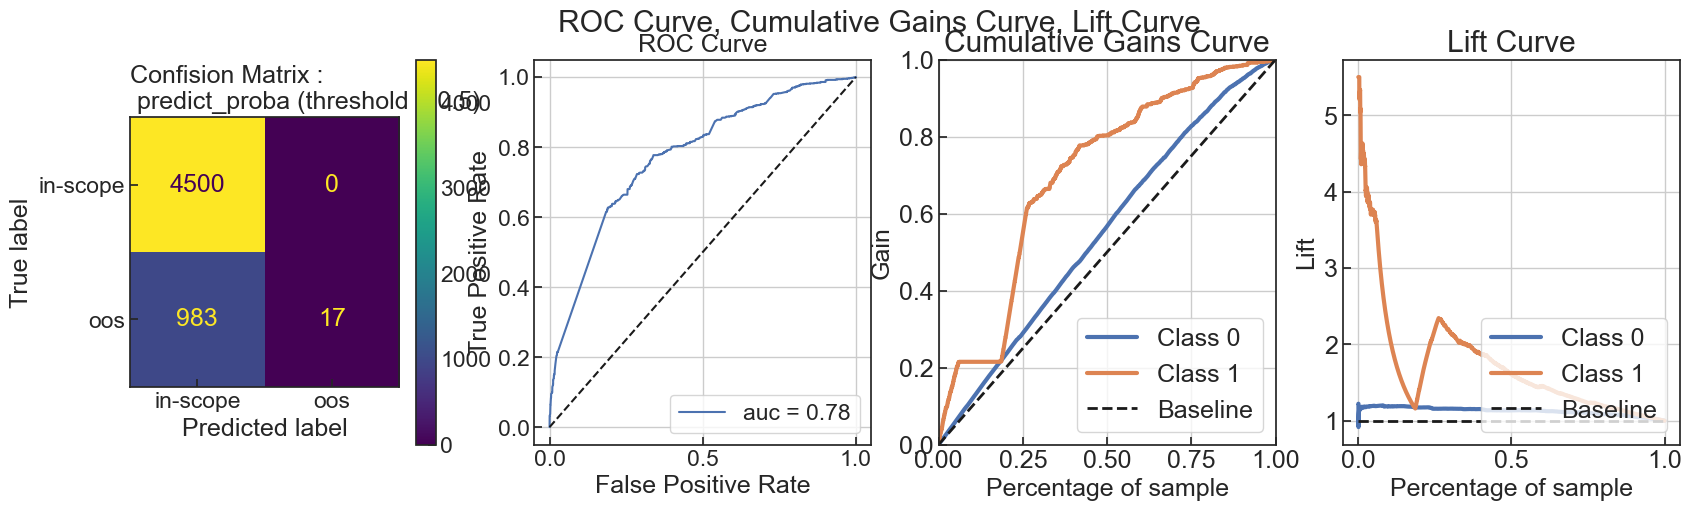

Time taken to run classification_report: 0.008732080459594727
XGBClassifier-grid  split :0.2 best params {'classifier__gamma': 0.3, 'classifier__n_estimators': 500}
accuracy: 0.8212727272727273
              precision    recall  f1-score  support
macro avg      0.910359  0.508500  0.467482   5500.0
weighted avg   0.853315  0.821273  0.743696   5500.0
######## calcAcc_score XGBClassifier end ########


In [38]:
# 5.5 Create different models and validate them
validateClassifiers(preprocessor_tfidf, df_train, TEXT_COLUMN, INTENT_COLUMN, 'clinc150-tfidf-oos')
validateClassifiers(preprocessor_count, df_train, TEXT_COLUMN, INTENT_COLUMN, 'clinc150-count-oos')

In [39]:
# show dataframe with gradient background
# different cmap options: https://matplotlib.org/stable/tutorials/colors/colormaps.html

cm = sns.light_palette("xkcd:golden", as_cmap=True)
out_df[out_df["data"].str.contains("oos")][model_building_cols].sort_values(by='test_acc', ascending=False).style.background_gradient(cmap=cm)
# data = Dataset.load_from_df(df[['userId', 'title', 'rating']], reader)



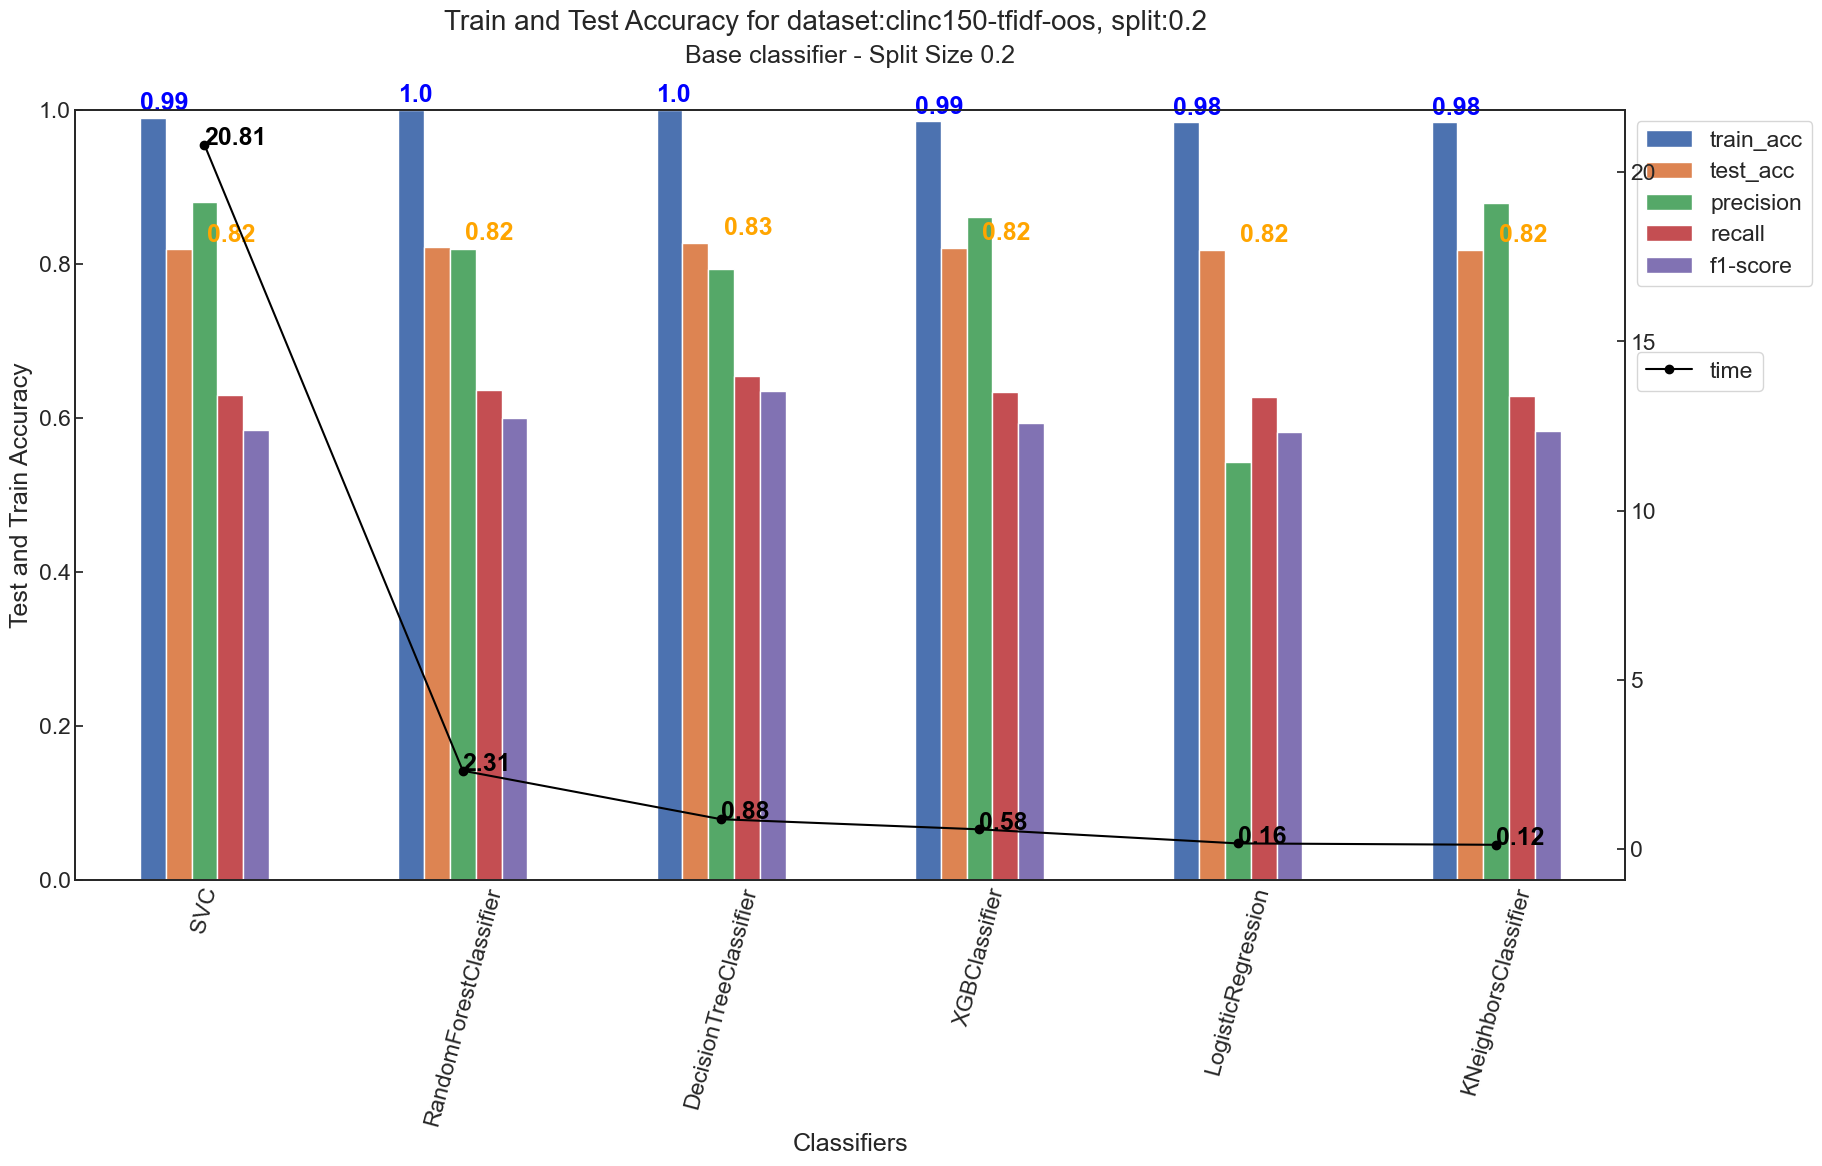

In [40]:
plotAccuracies(out_df, 0.2, 'No', 'clinc150-tfidf-oos')

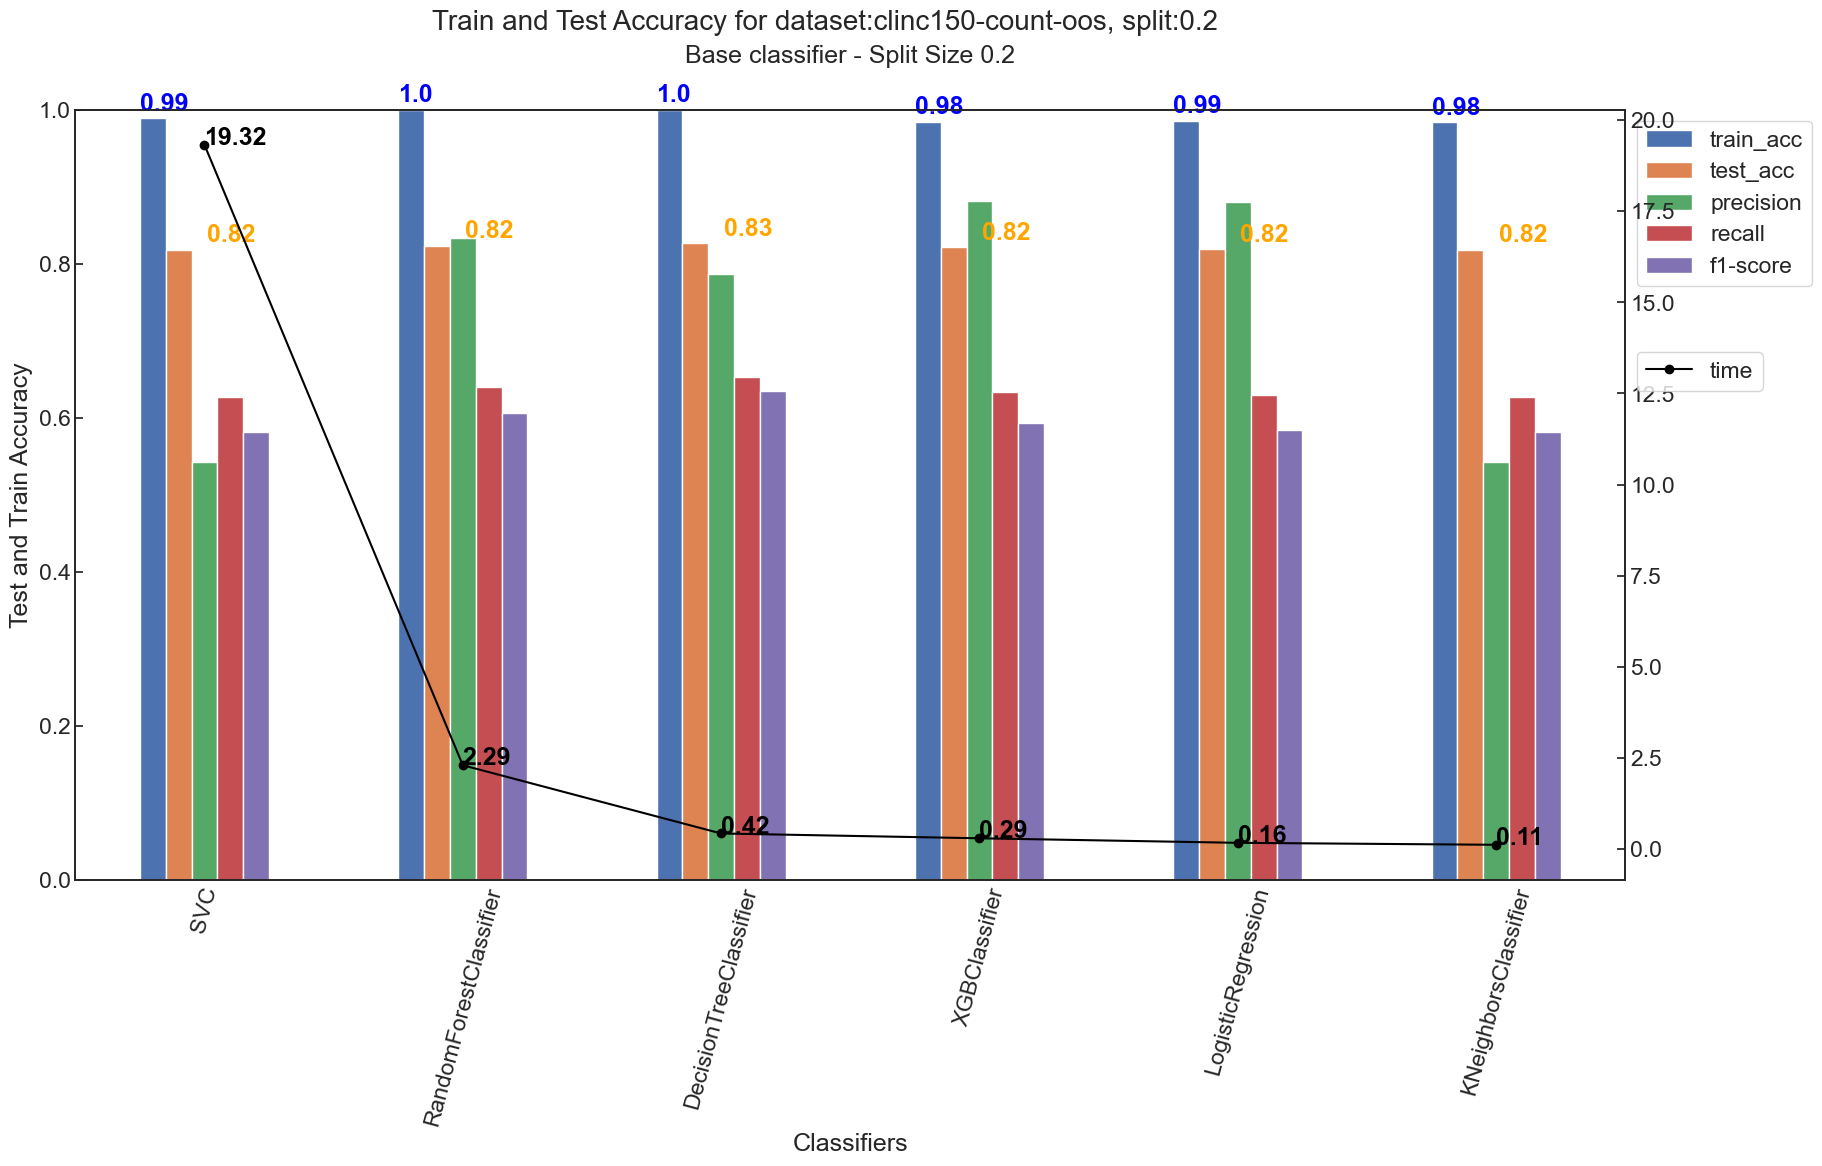

In [41]:
plotAccuracies(out_df, 0.2, 'No', 'clinc150-count-oos')

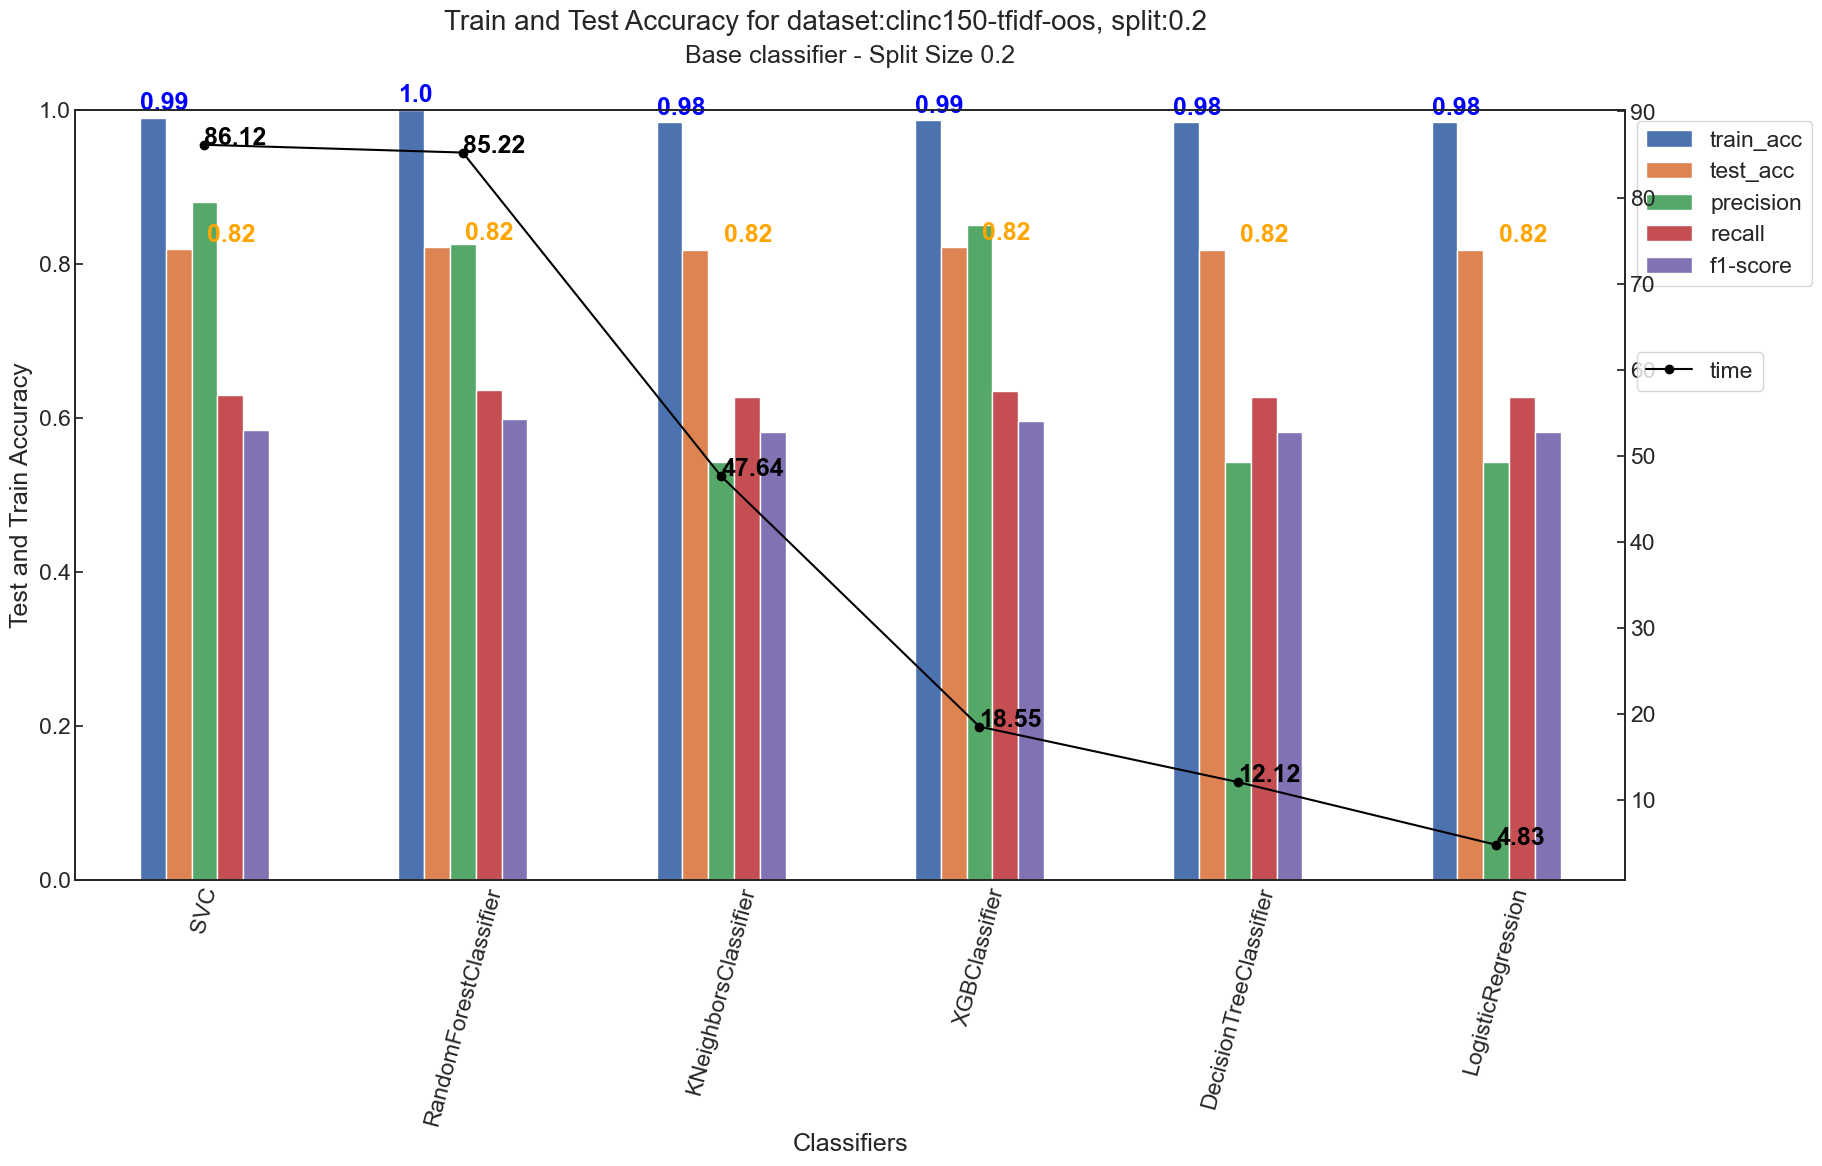

In [42]:
plotAccuracies(out_df, 0.2, 'halving', 'clinc150-tfidf-oos')

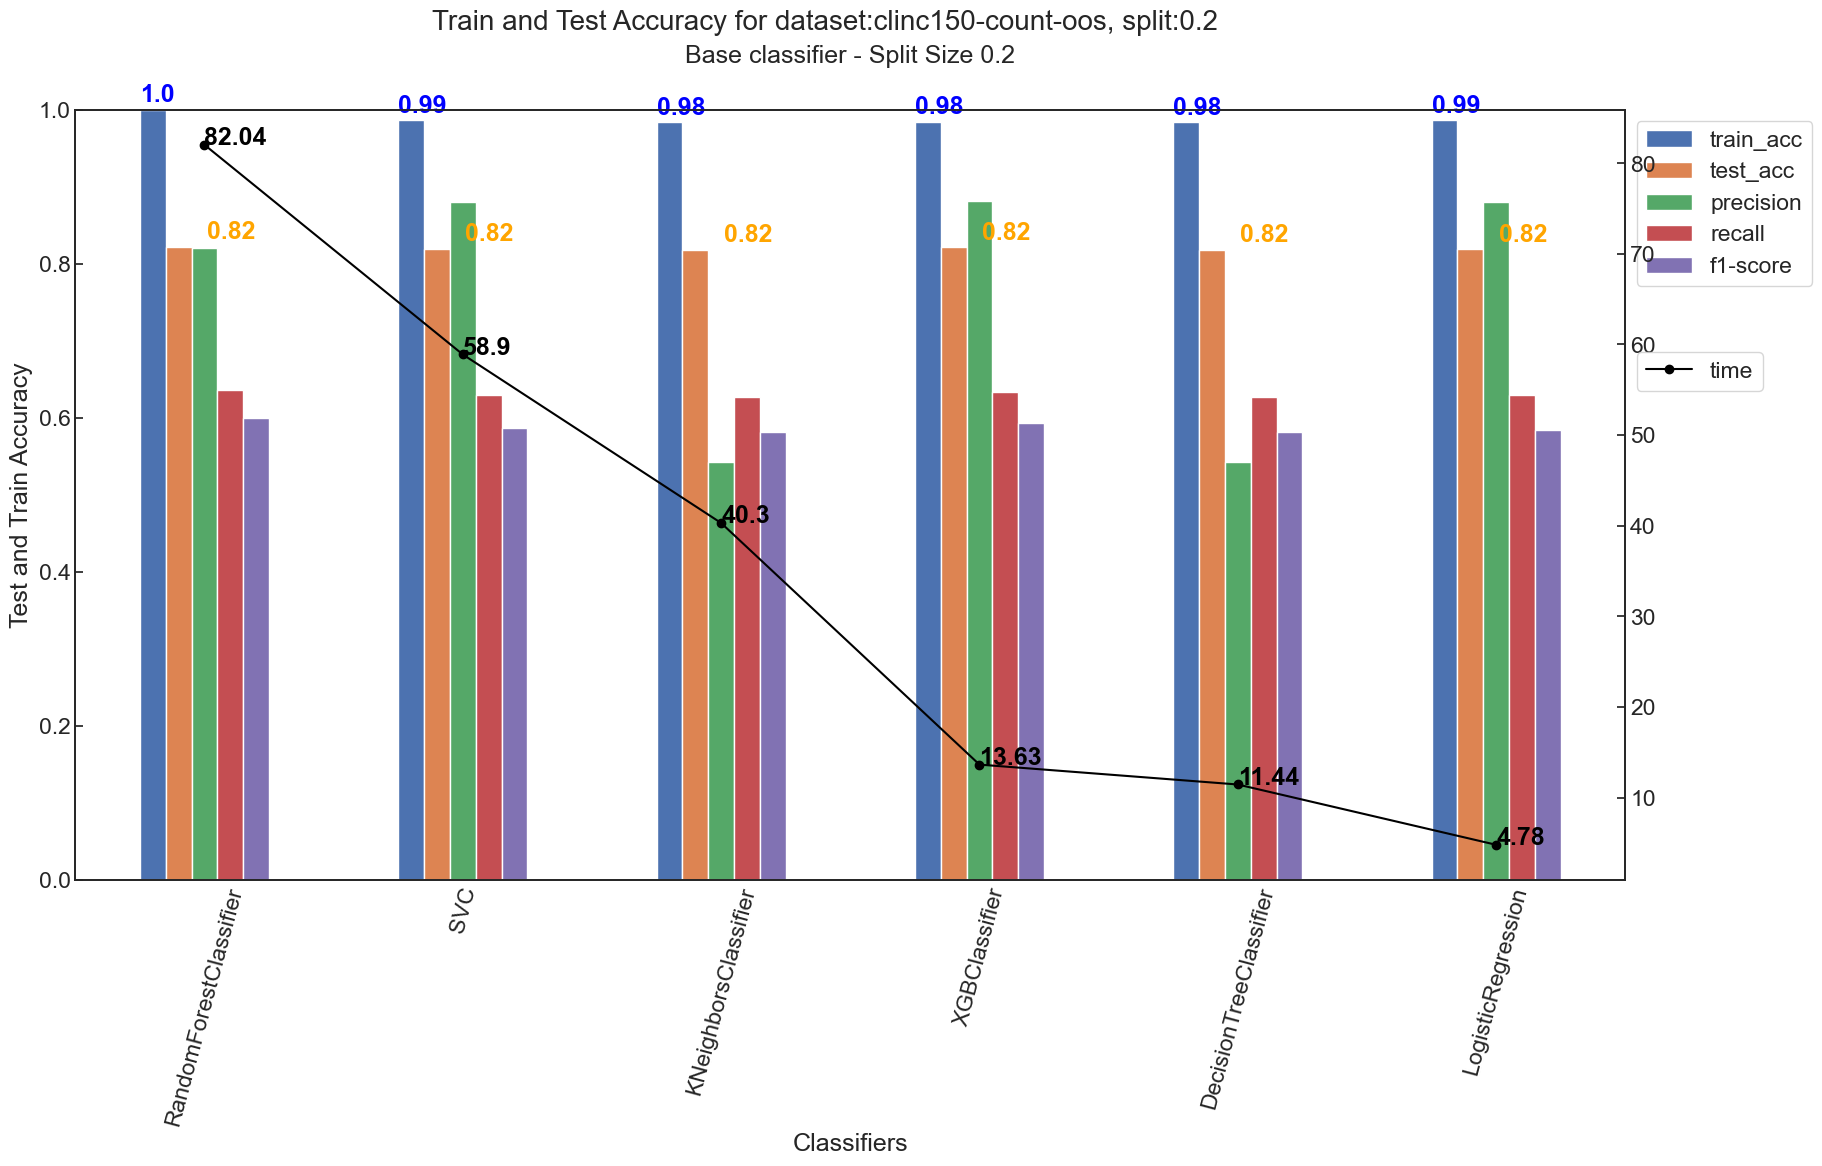

In [43]:
plotAccuracies(out_df, 0.2, 'halving', 'clinc150-count-oos')

# 5.4
- DecisionTreeClassifier irrespective of the vectorizer used is a good model with test accuracy of 0.82. This also has slightly better numbers in terms of precision and recall for oos identification.
- KNieghborsClassifier is the fastest but with accuracy of 0.81 which is comparable with dummy as well as other models.


# 6. Deployment


In [44]:
# show dataframe with gradient background
# different cmap options: https://seaborn.pydata.org/generated/seaborn.light_palette.html

cm = sns.light_palette("seagreen", as_cmap=True)
# does not contain oos
out_df[~out_df["data"].str.contains("oos")][evaluation_cols].sort_values(by='val_acc', ascending=False).style.background_gradient(cmap=cm)



In [45]:
# show dataframe with gradient background
# different cmap options: https://seaborn.pydata.org/generated/seaborn.light_palette.html

cm = sns.light_palette("xkcd:golden", as_cmap=True)
# does not contain oos
out_df[out_df["data"].str.contains("oos")][evaluation_cols].sort_values(by='val_acc', ascending=False).style.background_gradient(cmap=cm)



# 7. Conclusion
- We have used 3 different models to identify the intent of the text.
    - SVC with TFIDF Vectorizer
    - LogisticRegression with Count Vectorizer
    - KNeighborsClassifier with Count Vectorizer
- We have used 2 different models to identify if the text is out of scope.
    - DecisionTreeClassifier
    - KNeighborsClassifier

- Further improvements can be done by using different models and tuning the hyperparameters.
- We can also use different vectorizers and see if that improves the accuracy.
- We can also improve the quality of the data by removing the stop words and incorporating lemmatization and stemming.